In [ ]:
#############################################################################
# zlib License
#
# (C) 2024 Cristóvão Beirão da Cruz e Silva <cbeiraod@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

In [1]:
from pathlib import Path
import sqlite3
import pandas
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import mplhep
from math import floor

from SEUhelper import *

import sys, os
path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, 'TestBeam')))
if (not (path2add in sys.path)) :
    sys.path.append(path2add)

In [2]:
# This notebook is for analysing the data from the 11th of May 2024, the SEU testing performed at Northwestern Medicine Proton Center

# Four boards were used for this testing: ET2p01_Bare_14, ET2p01_Bare_11, ET2p01_Bare_15 and ET2p01_Bare_12
# At one point during the campaign, one of the power supplies stopped working, so we need to look at the data and keep that in mind

start_time = datetime.datetime(2024, 5, 11, 9, 0, 0)
end_time = datetime.datetime(2024, 5, 11, 23, 0, 0)

base_directory = Path("/Volumes/AnalysisData/SEU/SEU_11May2024/")

power_file = base_directory/"PowerHistorySEU11May2024.sqlite"
config_directory = base_directory/"ChipConfig"
output_dir = base_directory/"AnalysisOutput"
output_dir.mkdir(exist_ok=True)

chip_names = [
    "ET2p01_BARE_14", # Ch0
    "ET2p01_BARE_11", # Ch1
    "ET2p01_BARE_15", # Ch2
    "ET2p01_BARE_12", # Ch3
]

power_connections = {
    "ET2.01 Bare Board 14": {
        "Analog": "Power1:Analog",
        "Digital": "Power1:Digital",
    },
    "ET2.01 Bare Board 11": {
        "Analog": "Power2:Analog",
        "Digital": "Power2:Digital",
    },
    "ET2.01 Bare Board 15": {
        "Analog": "Power3:Analog",
        "Digital": "Power3:Digital",
    },
    "ET2.01 Bare Board 12": {
        "Analog": "Power4:Analog",
        "Digital": "Power4:Digital",
    },
}

run_info = [
    {
        "name": "Run_May11SEU_1",
        #"extra_begin": datetime.datetime(2024, 1, 27, 9, 10, 0),  # Optional: Used if we want to add an additional time for the per run plotting
        "start": datetime.datetime(2024, 5, 11, 11, 6, 17),
        "stop": datetime.datetime(2024, 5, 11, 11, 10, 53),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [
            datetime.datetime(2024, 5, 11, 11, 0, 2),
            datetime.datetime(2024, 5, 11, 11, 1, 41),
            datetime.datetime(2024, 5, 11, 11, 3, 18),
            datetime.datetime(2024, 5, 11, 11, 4, 56),
        ],
        "post_config_times": [
            None,
            None,
            None,
            None,
        ],
        "config_before": True,
        #"extra_run_info": ["Run_SEUJan24_16"],  # Optional: Used if we want to add some info from another run in the extra run list
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "off",
    },
    {
        "name": "Run_May11SEU_2",
        "start": datetime.datetime(2024, 5, 11, 11, 23, 27),
        "stop": datetime.datetime(2024, 5, 11, 11, 29, 32),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [
            datetime.datetime(2024, 5, 11, 11, 18, 19),
            datetime.datetime(2024, 5, 11, 11, 19, 57),
            datetime.datetime(2024, 5, 11, 11, 21, 35),
            datetime.datetime(2024, 5, 11, 11, 23, 13),
        ],
        "post_config_times": [
            datetime.datetime(2024, 5, 11, 11, 31, 59),
            datetime.datetime(2024, 5, 11, 11, 33, 37),
            datetime.datetime(2024, 5, 11, 11, 35, 15),
            datetime.datetime(2024, 5, 11, 11, 36, 53),
        ],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "off",
    },
    {
        "name": "Run_May11SEU_3",
        "start": datetime.datetime(2024, 5, 11, 11, 50, 50),
        "stop": datetime.datetime(2024, 5, 11, 11, 51, 11),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [
            datetime.datetime(2024, 5, 11, 11, 41, 11),
            datetime.datetime(2024, 5, 11, 11, 42, 49),
            datetime.datetime(2024, 5, 11, 11, 44, 27),
            datetime.datetime(2024, 5, 11, 11, 46, 5),
        ],
        "post_config_times": [
            datetime.datetime(2024, 5, 11, 11, 52, 58),
            datetime.datetime(2024, 5, 11, 11, 54, 36),
            datetime.datetime(2024, 5, 11, 11, 56, 14),
            datetime.datetime(2024, 5, 11, 11, 57, 52),
        ],
        "config_before": True,
        "fluence": 3.99E+10,
        "fluence_type": "p",
        "pixel_TMR": "off",
    },
    {
        "name": "Run_May11SEU_4",
        "start": datetime.datetime(2024, 5, 11, 12, 7, 10),
        "stop": datetime.datetime(2024, 5, 11, 12, 8, 21),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [
            datetime.datetime(2024, 5, 11, 12, 1, 57),
            datetime.datetime(2024, 5, 11, 12, 3, 35),
            datetime.datetime(2024, 5, 11, 12, 5, 13),
            datetime.datetime(2024, 5, 11, 12, 6, 51),
        ],
        "post_config_times": [
            datetime.datetime(2024, 5, 11, 12, 10, 8),
            datetime.datetime(2024, 5, 11, 12, 11, 46),
            datetime.datetime(2024, 5, 11, 12, 13, 24),
            datetime.datetime(2024, 5, 11, 12, 15, 2),
        ],
        "config_before": True,
        "fluence": 2.24E+11,
        "fluence_type": "p",
        "pixel_TMR": "off",
    },
    {
        "name": "Run_May11SEU_5",
        "start": datetime.datetime(2024, 5, 11, 12, 26, 22),
        "stop": datetime.datetime(2024, 5, 11, 12, 27, 32),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [
            datetime.datetime(2024, 5, 11, 12, 19, 19),
            datetime.datetime(2024, 5, 11, 12, 20, 57),
            datetime.datetime(2024, 5, 11, 12, 22, 35),
            datetime.datetime(2024, 5, 11, 12, 24, 13),
        ],
        "post_config_times": [
            datetime.datetime(2024, 5, 11, 12, 29, 33),
            datetime.datetime(2024, 5, 11, 12, 31, 11),
            datetime.datetime(2024, 5, 11, 12, 32, 49),
            datetime.datetime(2024, 5, 11, 12, 34, 27),
        ],
        "config_before": True,
        "fluence": 1.24E+12,
        "fluence_type": "p",
        "pixel_TMR": "off",
    },
    {
        "name": "Run_May11SEU_6",
        "start": datetime.datetime(2024, 5, 11, 12, 46, 45),
        "stop": datetime.datetime(2024, 5, 11, 12, 50, 11),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [
            datetime.datetime(2024, 5, 11, 12, 39, 8),
            datetime.datetime(2024, 5, 11, 12, 40, 46),
            datetime.datetime(2024, 5, 11, 12, 42, 24),
            datetime.datetime(2024, 5, 11, 12, 44, 2),
        ],
        "post_config_times": [
            datetime.datetime(2024, 5, 11, 12, 52, 28),
            datetime.datetime(2024, 5, 11, 12, 54, 6),
            datetime.datetime(2024, 5, 11, 12, 55, 44),
            datetime.datetime(2024, 5, 11, 12, 57, 22),
        ],
        "config_before": True,
        "fluence": 4.03E+12,
        "fluence_type": "p",
        "pixel_TMR": "off",
    },
    {
        "name": "Run_May11SEU_7",
        "start": datetime.datetime(2024, 5, 11, 13, 37, 0),
        "stop": datetime.datetime(2024, 5, 11, 13, 40, 26),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [
            datetime.datetime(2024, 5, 11, 13, 31, 58),
            datetime.datetime(2024, 5, 11, 13, 33, 36),
            datetime.datetime(2024, 5, 11, 13, 35, 14),
            datetime.datetime(2024, 5, 11, 13, 36, 52),
        ],
        "post_config_times": [
            datetime.datetime(2024, 5, 11, 13, 45, 6),
            datetime.datetime(2024, 5, 11, 13, 46, 44),
            datetime.datetime(2024, 5, 11, 13, 48, 22),
            datetime.datetime(2024, 5, 11, 13, 50, 0),
        ],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "off",
    },
    {
        "name": "Run_May11SEU_8",
        "start": datetime.datetime(2024, 5, 11, 14, 14, 41),
        "stop": datetime.datetime(2024, 5, 11, 14, 18, 8),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [
            datetime.datetime(2024, 5, 11, 14, 3, 44),
            datetime.datetime(2024, 5, 11, 14, 5, 22),
            datetime.datetime(2024, 5, 11, 14, 7, 0),
            datetime.datetime(2024, 5, 11, 14, 8, 38),
        ],
        "post_config_times": [
            datetime.datetime(2024, 5, 11, 14, 19, 46),
            datetime.datetime(2024, 5, 11, 14, 21, 24),
            datetime.datetime(2024, 5, 11, 14, 23, 2),
            datetime.datetime(2024, 5, 11, 14, 24, 40),
        ],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "off",
    },
    {
        "name": "Run_May11SEU_9",
        "start": datetime.datetime(2024, 5, 11, 14, 48, 17),
        "stop": datetime.datetime(2024, 5, 11, 14, 50, 59),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [
            datetime.datetime(2024, 5, 11, 14, 34, 41),
            datetime.datetime(2024, 5, 11, 14, 36, 19),
            datetime.datetime(2024, 5, 11, 14, 37, 58),
            datetime.datetime(2024, 5, 11, 14, 39, 36),
        ],
        "post_config_times": [
            datetime.datetime(2024, 5, 11, 14, 52, 37),
            datetime.datetime(2024, 5, 11, 14, 54, 15),
            datetime.datetime(2024, 5, 11, 14, 55, 53),
            datetime.datetime(2024, 5, 11, 14, 57, 31),
        ],
        "config_before": True,
        "fluence": 1.07E+12,
        "fluence_type": "p",
        "pixel_TMR": "off",
    },
    {
        "name": "Run_May11SEU_10",
        "start": datetime.datetime(2024, 5, 11, 15, 10, 43),
        "stop": datetime.datetime(2024, 5, 11, 15, 14, 8),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [
            datetime.datetime(2024, 5, 11, 15, 4, 55),
            datetime.datetime(2024, 5, 11, 15, 6, 33),
            datetime.datetime(2024, 5, 11, 15, 8, 11),
            datetime.datetime(2024, 5, 11, 15, 9, 49),
        ],
        "post_config_times": [
            datetime.datetime(2024, 5, 11, 15, 16, 20),
            datetime.datetime(2024, 5, 11, 15, 17, 58),
            datetime.datetime(2024, 5, 11, 15, 19, 36),
            datetime.datetime(2024, 5, 11, 15, 21, 14),
        ],
        "config_before": True,
        "fluence": 4.01E+12,
        "fluence_type": "p",
        "pixel_TMR": "off",
    },
    {
        "name": "Run_May11SEU_11",
        "start": datetime.datetime(2024, 5, 11, 15, 55, 48),
        "stop": datetime.datetime(2024, 5, 11, 15, 56, 59),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [
            datetime.datetime(2024, 5, 11, 15, 50, 36),
            datetime.datetime(2024, 5, 11, 15, 52, 14),
            datetime.datetime(2024, 5, 11, 15, 53, 52),
            datetime.datetime(2024, 5, 11, 15, 55, 30),
        ],
        "post_config_times": [
            datetime.datetime(2024, 5, 11, 15, 59, 41),
            datetime.datetime(2024, 5, 11, 16, 1, 19),
            datetime.datetime(2024, 5, 11, 16, 2, 57),
            datetime.datetime(2024, 5, 11, 16, 4, 35),
        ],
        "config_before": True,
        "fluence": 2.26E+12,
        "fluence_type": "p",
        "pixel_TMR": "off",
    },
    {
        "name": "Run_May11SEU_12",
        "start": datetime.datetime(2024, 5, 11, 16, 19, 14),
        "stop": datetime.datetime(2024, 5, 11, 16, 20, 47),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [
            datetime.datetime(2024, 5, 11, 16, 11, 59),
            datetime.datetime(2024, 5, 11, 16, 13, 38),
            datetime.datetime(2024, 5, 11, 16, 15, 16),
            datetime.datetime(2024, 5, 11, 16, 16, 54),
        ],
        "post_config_times": [
            None,
            None,
            None,
            None,
        ],
        "config_before": True,
        "fluence": 6.41E+10,
        "fluence_type": "p",
        "pixel_TMR": "off",
    },
    {
        "name": "Run_May11SEU_13",
        "start": datetime.datetime(2024, 5, 11, 16, 36, 24),
        "stop": datetime.datetime(2024, 5, 11, 16, 41, 50),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [
            datetime.datetime(2024, 5, 11, 16, 30, 38),
            datetime.datetime(2024, 5, 11, 16, 32, 16),
            datetime.datetime(2024, 5, 11, 16, 33, 54),
            datetime.datetime(2024, 5, 11, 16, 35, 33),
        ],
        "post_config_times": [
            datetime.datetime(2024, 5, 11, 16, 43, 41),
            datetime.datetime(2024, 5, 11, 16, 45, 19),
            datetime.datetime(2024, 5, 11, 16, 46, 57),
            datetime.datetime(2024, 5, 11, 16, 48, 35),
        ],
        "config_before": True,
        "fluence": 6.39E+12,
        "fluence_type": "p",
        "pixel_TMR": "off",
    },
    {
        "name": "Run_May11SEU_14",
        "start": datetime.datetime(2024, 5, 11, 17, 1, 31),
        "stop": datetime.datetime(2024, 5, 11, 17, 6, 57),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [
            datetime.datetime(2024, 5, 11, 16, 56, 22),
            datetime.datetime(2024, 5, 11, 16, 58, 0),
            datetime.datetime(2024, 5, 11, 16, 59, 38),
            datetime.datetime(2024, 5, 11, 17, 1, 16),
        ],
        "post_config_times": [
            datetime.datetime(2024, 5, 11, 17, 8, 53),
            datetime.datetime(2024, 5, 11, 17, 10, 31),
            datetime.datetime(2024, 5, 11, 17, 12, 10),
            datetime.datetime(2024, 5, 11, 17, 13, 48),
        ],
        "config_before": True,
        "fluence": 1.14E+13,
        "fluence_type": "p",
        "pixel_TMR": "off",
    },
    {
        "name": "Run_May11SEU_15",
        "start": datetime.datetime(2024, 5, 11, 17, 36, 56),
        "stop": datetime.datetime(2024, 5, 11, 17, 42, 22),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [
            datetime.datetime(2024, 5, 11, 17, 19, 58),
            datetime.datetime(2024, 5, 11, 17, 21, 36),
            datetime.datetime(2024, 5, 11, 17, 23, 14),
            datetime.datetime(2024, 5, 11, 17, 24, 52),
        ],
        "post_config_times": [
            datetime.datetime(2024, 5, 11, 17, 44, 2),
            datetime.datetime(2024, 5, 11, 17, 45, 40),
            datetime.datetime(2024, 5, 11, 17, 47, 18),
            datetime.datetime(2024, 5, 11, 17, 48, 56),
        ],
        "config_before": True,
        "fluence": 1.16E+13,
        "fluence_type": "p",
        "pixel_TMR": "mixed",
    },
    {
        "name": "Run_May11SEU_16",
        "start": datetime.datetime(2024, 5, 11, 18, 14, 15),
        "stop": datetime.datetime(2024, 5, 11, 18, 19, 41),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [
            datetime.datetime(2024, 5, 11, 18, 7, 46),
            datetime.datetime(2024, 5, 11, 18, 9, 24),
            datetime.datetime(2024, 5, 11, 18, 11, 3),
            datetime.datetime(2024, 5, 11, 18, 12, 41),
        ],
        "post_config_times": [
            datetime.datetime(2024, 5, 11, 18, 21, 33),
            datetime.datetime(2024, 5, 11, 18, 23, 11),
            datetime.datetime(2024, 5, 11, 18, 24, 49),
            datetime.datetime(2024, 5, 11, 18, 26, 27),
        ],
        "config_before": True,
        "fluence": 1.17E+13,
        "fluence_type": "p",
        "pixel_TMR": "on",
    },
    {
        "name": "Run_May11SEU_17",
        "start": datetime.datetime(2024, 5, 11, 18, 37, 27),
        "stop": datetime.datetime(2024, 5, 11, 18, 43, 54),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [
            datetime.datetime(2024, 5, 11, 18, 32, 0),
            datetime.datetime(2024, 5, 11, 18, 33, 38),
            datetime.datetime(2024, 5, 11, 18, 35, 16),
            datetime.datetime(2024, 5, 11, 18, 36, 54),
        ],
        "post_config_times": [
            None,  # datetime.datetime(2024, 5, 11, 18, 45, 22),  # There was an SEU event on this power supply, so we must ignore this dump
            datetime.datetime(2024, 5, 11, 18, 47, 0),
            datetime.datetime(2024, 5, 11, 18, 48, 38),
            datetime.datetime(2024, 5, 11, 18, 50, 16),
        ],
        "config_before": True,
        "fluence": 1.42E+13,
        "fluence_type": "p",
        "pixel_TMR": "on",
    },
]
extra_run_info = [
]
test_run_info = [
    {
        "name": "Run_Test_short_May11_1",
        "start": datetime.datetime(2024, 5, 11, 11, 9, 19),
        "stop": datetime.datetime(2024, 5, 11, 11, 10, 27),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Run_Test_short_May11_2",
        "start": datetime.datetime(2024, 5, 11, 11, 13, 54),
        "stop": datetime.datetime(2024, 5, 11, 11, 15, 3),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Run_Test_short_May11_3",
        "start": datetime.datetime(2024, 5, 11, 11, 15, 19),
        "stop": datetime.datetime(2024, 5, 11, 11, 16, 28),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Missing_Run_May11_1",
        "start": datetime.datetime(2024, 5, 11, 13, 52, 57),
        "stop": datetime.datetime(2024, 5, 11, 13, 53, 20),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
        "has_data": False,
    },
    {
        "name": "Missing_Run_May11_2",
        "start": datetime.datetime(2024, 5, 11, 14, 39, 51),
        "stop": datetime.datetime(2024, 5, 11, 14, 40, 12),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
        "has_data": False,
    },
    {
        "name": "Run_Test_short_May11_4",
        "start": datetime.datetime(2024, 5, 11, 14, 41, 46),
        "stop": datetime.datetime(2024, 5, 11, 14, 42, 7),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Run_Test_short_May11_5",
        "start": datetime.datetime(2024, 5, 11, 14, 42, 48),
        "stop": datetime.datetime(2024, 5, 11, 14, 43, 10),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Run_Test_short_May11_6",
        "start": datetime.datetime(2024, 5, 11, 14, 44, 0),
        "stop": datetime.datetime(2024, 5, 11, 14, 44, 22),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Run_Test_short_May11_7",
        "start": datetime.datetime(2024, 5, 11, 14, 44, 25),
        "stop": datetime.datetime(2024, 5, 11, 14, 44, 48),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Run_Test_short_May11_8",
        "start": datetime.datetime(2024, 5, 11, 14, 45, 53),
        "stop": datetime.datetime(2024, 5, 11, 14, 46, 15),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Missing_Run_May11_3",
        "start": datetime.datetime(2024, 5, 11, 15, 0, 38),
        "stop": datetime.datetime(2024, 5, 11, 15, 1, 0),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
        "has_data": False,
    },
    {
        "name": "Missing_Run_May11_4",
        "start": datetime.datetime(2024, 5, 11, 15, 1, 11),
        "stop": datetime.datetime(2024, 5, 11, 15, 1, 33),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
        "has_data": False,
    },
    {
        "name": "Run_Test_short_May11_9",
        "start": datetime.datetime(2024, 5, 11, 15, 2, 5),
        "stop": datetime.datetime(2024, 5, 11, 15, 2, 28),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Missing_Run_May11_5",
        "start": datetime.datetime(2024, 5, 11, 15, 35, 7),
        "stop": datetime.datetime(2024, 5, 11, 15, 35, 29),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
        "has_data": False,
    },
    {
        "name": "Missing_Run_May11_6",
        "start": datetime.datetime(2024, 5, 11, 15, 35, 55),
        "stop": datetime.datetime(2024, 5, 11, 15, 36, 18),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
        "has_data": False,
    },
    {
        "name": "Run_Test_short_May11_11",
        "start": datetime.datetime(2024, 5, 11, 15, 36, 33),
        "stop": datetime.datetime(2024, 5, 11, 15, 36, 56),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Missing_Run_May11_7",
        "start": datetime.datetime(2024, 5, 11, 15, 37, 23),
        "stop": datetime.datetime(2024, 5, 11, 15, 37, 47),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
        "has_data": False,
    },
    {
        "name": "Run_Test_short_May11_12",
        "start": datetime.datetime(2024, 5, 11, 15, 38, 38),
        "stop": datetime.datetime(2024, 5, 11, 15, 39, 2),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Run_Test_short_May11_13",
        "start": datetime.datetime(2024, 5, 11, 15, 40, 13),
        "stop": datetime.datetime(2024, 5, 11, 15, 40, 36),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Run_Test_short_May11_14",
        "start": datetime.datetime(2024, 5, 11, 15, 44, 24),
        "stop": datetime.datetime(2024, 5, 11, 15, 44, 48),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Missing_Run_May11_8",
        "start": datetime.datetime(2024, 5, 11, 15, 45, 17),
        "stop": datetime.datetime(2024, 5, 11, 15, 45, 40),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
        "has_data": False,
    },
    {
        "name": "Run_Test_short_May11_15",
        "start": datetime.datetime(2024, 5, 11, 15, 47, 44),
        "stop": datetime.datetime(2024, 5, 11, 15, 48, 8),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Missing_Run_May11_9",
        "start": datetime.datetime(2024, 5, 11, 16, 8, 42),
        "stop": datetime.datetime(2024, 5, 11, 16, 9, 4),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
        "has_data": False,
    },
    {
        "name": "Run_Test_short_May11_16",
        "start": datetime.datetime(2024, 5, 11, 16, 9, 28),
        "stop": datetime.datetime(2024, 5, 11, 16, 9, 52),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Missing_Run_May11_10",
        "start": datetime.datetime(2024, 5, 11, 16, 21, 34),
        "stop": datetime.datetime(2024, 5, 11, 16, 21, 55),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
        "has_data": False,
    },
    {
        "name": "Run_Test_short_May11_17",
        "start": datetime.datetime(2024, 5, 11, 16, 22, 34),
        "stop": datetime.datetime(2024, 5, 11, 16, 22, 58),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Missing_Run_May11_11",
        "start": datetime.datetime(2024, 5, 11, 16, 25, 52),
        "stop": datetime.datetime(2024, 5, 11, 16, 26, 12),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
        "has_data": False,
    },
    {
        "name": "Missing_Run_May11_12",
        "start": datetime.datetime(2024, 5, 11, 16, 26, 47),
        "stop": datetime.datetime(2024, 5, 11, 16, 27, 11),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
        "has_data": False,
    },
    {
        "name": "Run_Test_short_May11_18",
        "start": datetime.datetime(2024, 5, 11, 16, 27, 44),
        "stop": datetime.datetime(2024, 5, 11, 16, 28, 5),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Run_Test_short_May11_19",
        "start": datetime.datetime(2024, 5, 11, 16, 52, 4),
        "stop": datetime.datetime(2024, 5, 11, 16, 52, 25),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Missing_Run_May11_13",
        "start": datetime.datetime(2024, 5, 11, 16, 52, 56),
        "stop": datetime.datetime(2024, 5, 11, 16, 53, 20),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
        "has_data": False,
    },
    {
        "name": "Run_Test_short_May11_20",
        "start": datetime.datetime(2024, 5, 11, 16, 53, 55),
        "stop": datetime.datetime(2024, 5, 11, 16, 54, 19),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Missing_Run_May11_14",
        "start": datetime.datetime(2024, 5, 11, 17, 16, 52),
        "stop": datetime.datetime(2024, 5, 11, 17, 17, 14),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
        "has_data": False,
    },
    {
        "name": "Run_Test_short_May11_21",
        "start": datetime.datetime(2024, 5, 11, 17, 17, 30),
        "stop": datetime.datetime(2024, 5, 11, 17, 17, 53),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Run_Test_short_May11_22",
        "start": datetime.datetime(2024, 5, 11, 17, 34, 26),
        "stop": datetime.datetime(2024, 5, 11, 11, 34, 48),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Missing_Run_May11_15",
        "start": datetime.datetime(2024, 5, 11, 18, 4, 54),
        "stop": datetime.datetime(2024, 5, 11, 18, 5, 15),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
        "has_data": False,
    },
    {
        "name": "Run_Test_short_May11_23",
        "start": datetime.datetime(2024, 5, 11, 18, 5, 33),
        "stop": datetime.datetime(2024, 5, 11, 18, 5, 56),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Missing_Run_May11_16",
        "start": datetime.datetime(2024, 5, 11, 18, 29, 6),
        "stop": datetime.datetime(2024, 5, 11, 18, 29, 27),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
        "has_data": False,
    },
    {
        "name": "Run_Test_short_May11_24",
        "start": datetime.datetime(2024, 5, 11, 18, 29, 44),
        "stop": datetime.datetime(2024, 5, 11, 18, 30, 7),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Run_Test_short_May11_25",
        "start": datetime.datetime(2024, 5, 11, 18, 51, 19),
        "stop": datetime.datetime(2024, 5, 11, 18, 51, 41),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Run_Test_short_May11_26",
        "start": datetime.datetime(2024, 5, 11, 18, 52, 52),
        "stop": datetime.datetime(2024, 5, 11, 18, 53, 16),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
    {
        "name": "Run_Test_short_May11_27",
        "start": datetime.datetime(2024, 5, 11, 18, 54, 45),
        "stop": datetime.datetime(2024, 5, 11, 18, 55, 9),
        "boards": ["ET2.01 Bare Board 14", "ET2.01 Bare Board 11", "ET2.01 Bare Board 15", "ET2.01 Bare Board 12"],
        "board_channels": [0, 1, 2, 3],
        "pre_config_times": [],
        "post_config_times": [],
        "config_before": True,
        "fluence": 0,
        "fluence_type": None,
        "pixel_TMR": "on",
    },
]
run_info_backup = run_info
joined_config_analysis = {
    "Run1_alt": [
        [
            datetime.datetime(2024, 5, 11, 11, 0, 2),
            datetime.datetime(2024, 5, 11, 11, 1, 41),
            datetime.datetime(2024, 5, 11, 11, 3, 18),
            datetime.datetime(2024, 5, 11, 11, 4, 56),
        ],
        [
            datetime.datetime(2024, 5, 11, 11, 18, 19),
            datetime.datetime(2024, 5, 11, 11, 19, 57),
            datetime.datetime(2024, 5, 11, 11, 21, 35),
            datetime.datetime(2024, 5, 11, 11, 23, 13),
        ],
                 ],
    "Run12_alt": [
        [
            datetime.datetime(2024, 5, 11, 16, 11, 59),
            datetime.datetime(2024, 5, 11, 16, 13, 38),
            datetime.datetime(2024, 5, 11, 16, 15, 16),
            datetime.datetime(2024, 5, 11, 16, 16, 54),
        ],
        [
            datetime.datetime(2024, 5, 11, 16, 30, 38),
            datetime.datetime(2024, 5, 11, 16, 32, 16),
            datetime.datetime(2024, 5, 11, 16, 33, 54),
            datetime.datetime(2024, 5, 11, 16, 35, 33),
        ],
                 ],
    #"Kr": [[datetime.datetime(2024, 4, 25, 1, 44, 38)], [datetime.datetime(2024, 4, 25, 2, 28, 38)]],
}

# Power Monitoring

In [3]:
power_directory = output_dir/"PowerPlots"
power_directory.mkdir(exist_ok=True)

with sqlite3.connect(power_file) as sqlite3_connection:
    data_df = pandas.read_sql('SELECT * FROM power_v2', sqlite3_connection, index_col=None)
    data_df['Time'] = pandas.to_datetime(data_df['timestamp'], format='mixed')

    # Remove data that is outside the range of the campaign
    data_df = data_df.loc[data_df['Time'] >= start_time]
    data_df = data_df.loc[data_df['Time'] <= end_time].copy()

    data_df['V'] = data_df['V'].astype(float)
    data_df['I'] = data_df['I'].astype(float)

    print("Timestamps in power database file cover range:")
    print("Min:", data_df['Time'].min())
    print("Max", data_df['Time'].max())

    #print(data_df)

    vref_df = data_df.loc[data_df['Channel'] == 'VRef']
    #ws_df = data_df.loc[data_df['Channel'] == 'WS']
    wsana_df = data_df.loc[data_df['Channel'] == 'WSAnalog']
    wsdig_df = data_df.loc[data_df['Channel'] == 'WSDigital']

Timestamps in power database file cover range:
Min: 2024-05-11 09:00:00.104473
Max 2024-05-11 19:17:16.507937


## VRef

Plot VRef over time so we can find the range of times where we can be confident the data is ok

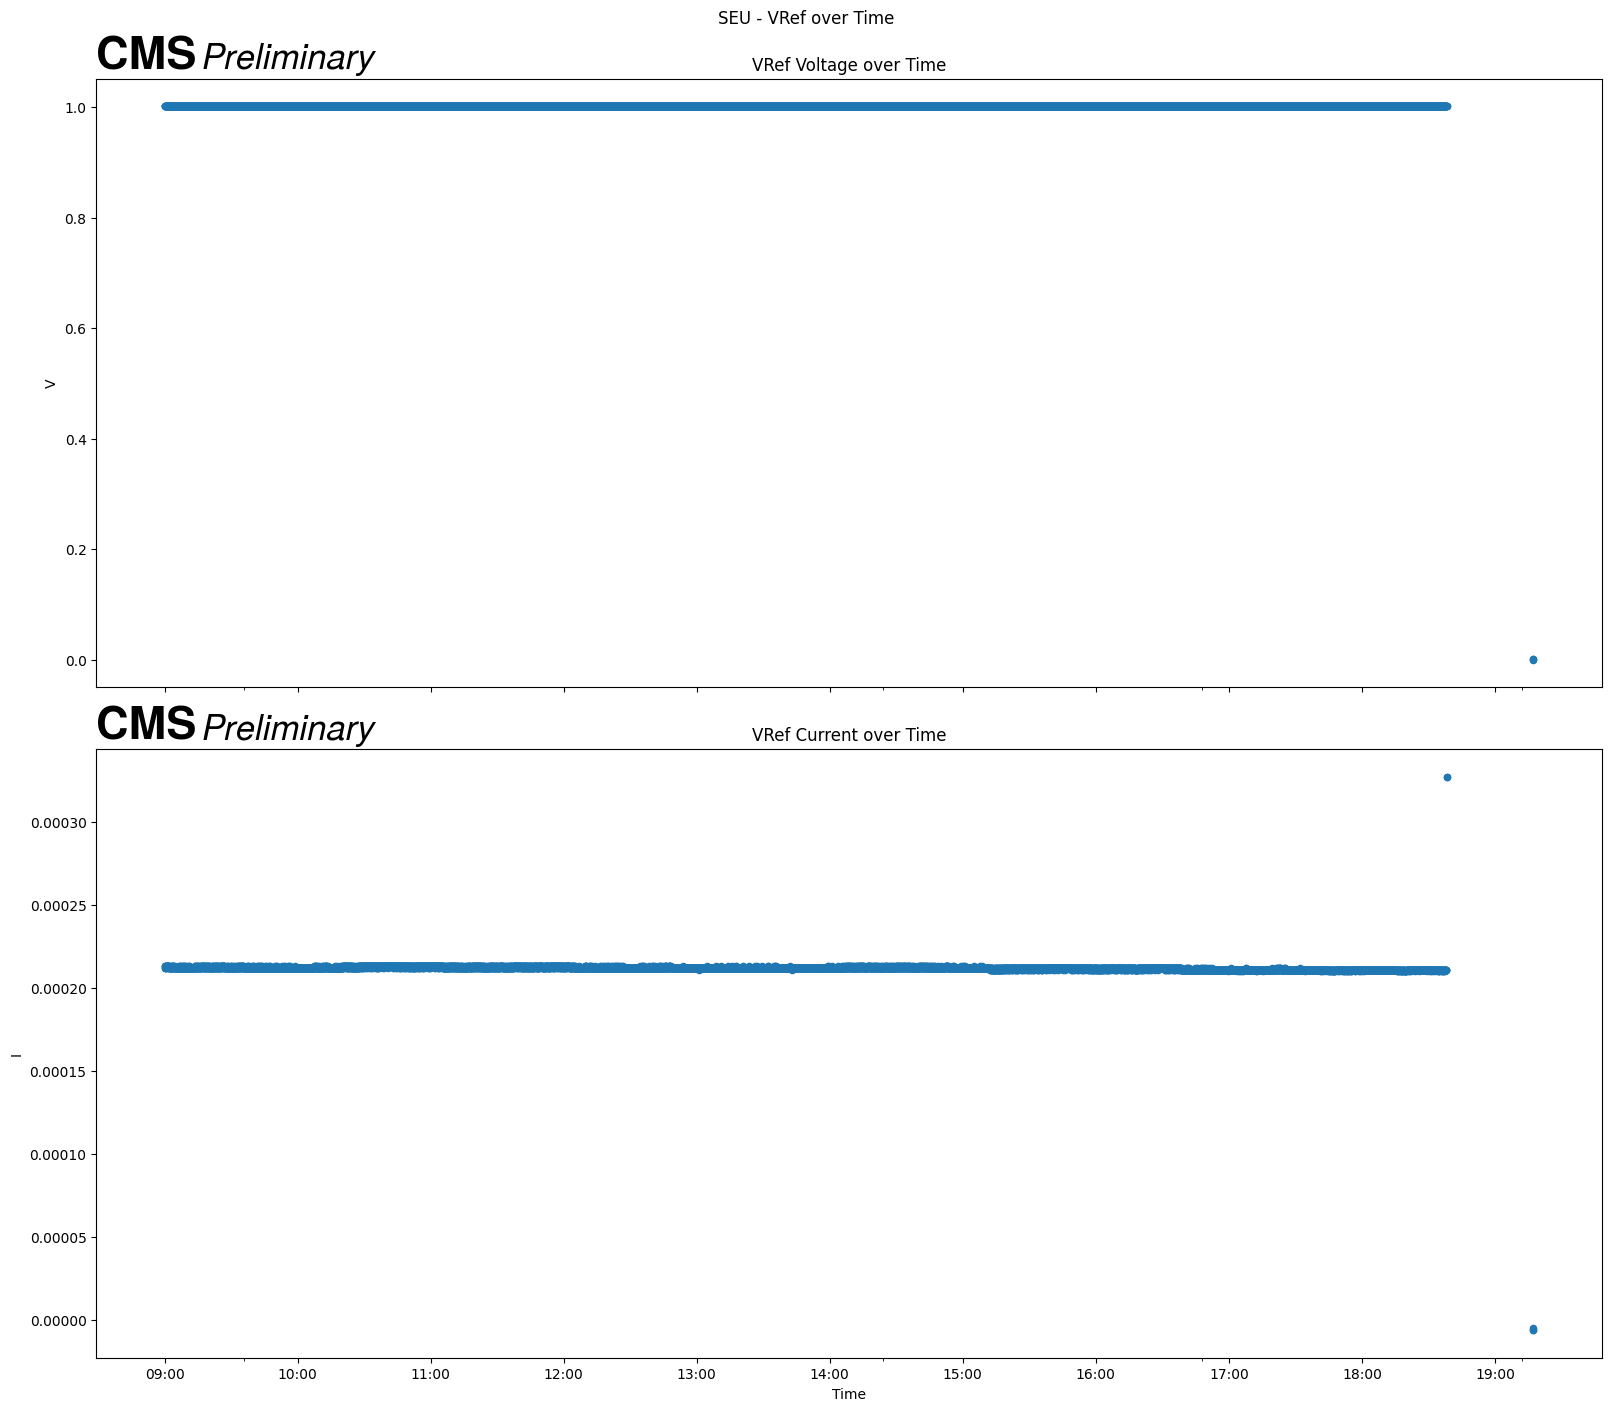

In [4]:
plotVRefPower(vref_df, 'SEU - VRef over Time', power_directory, True)

## ET2.1 Bare 14

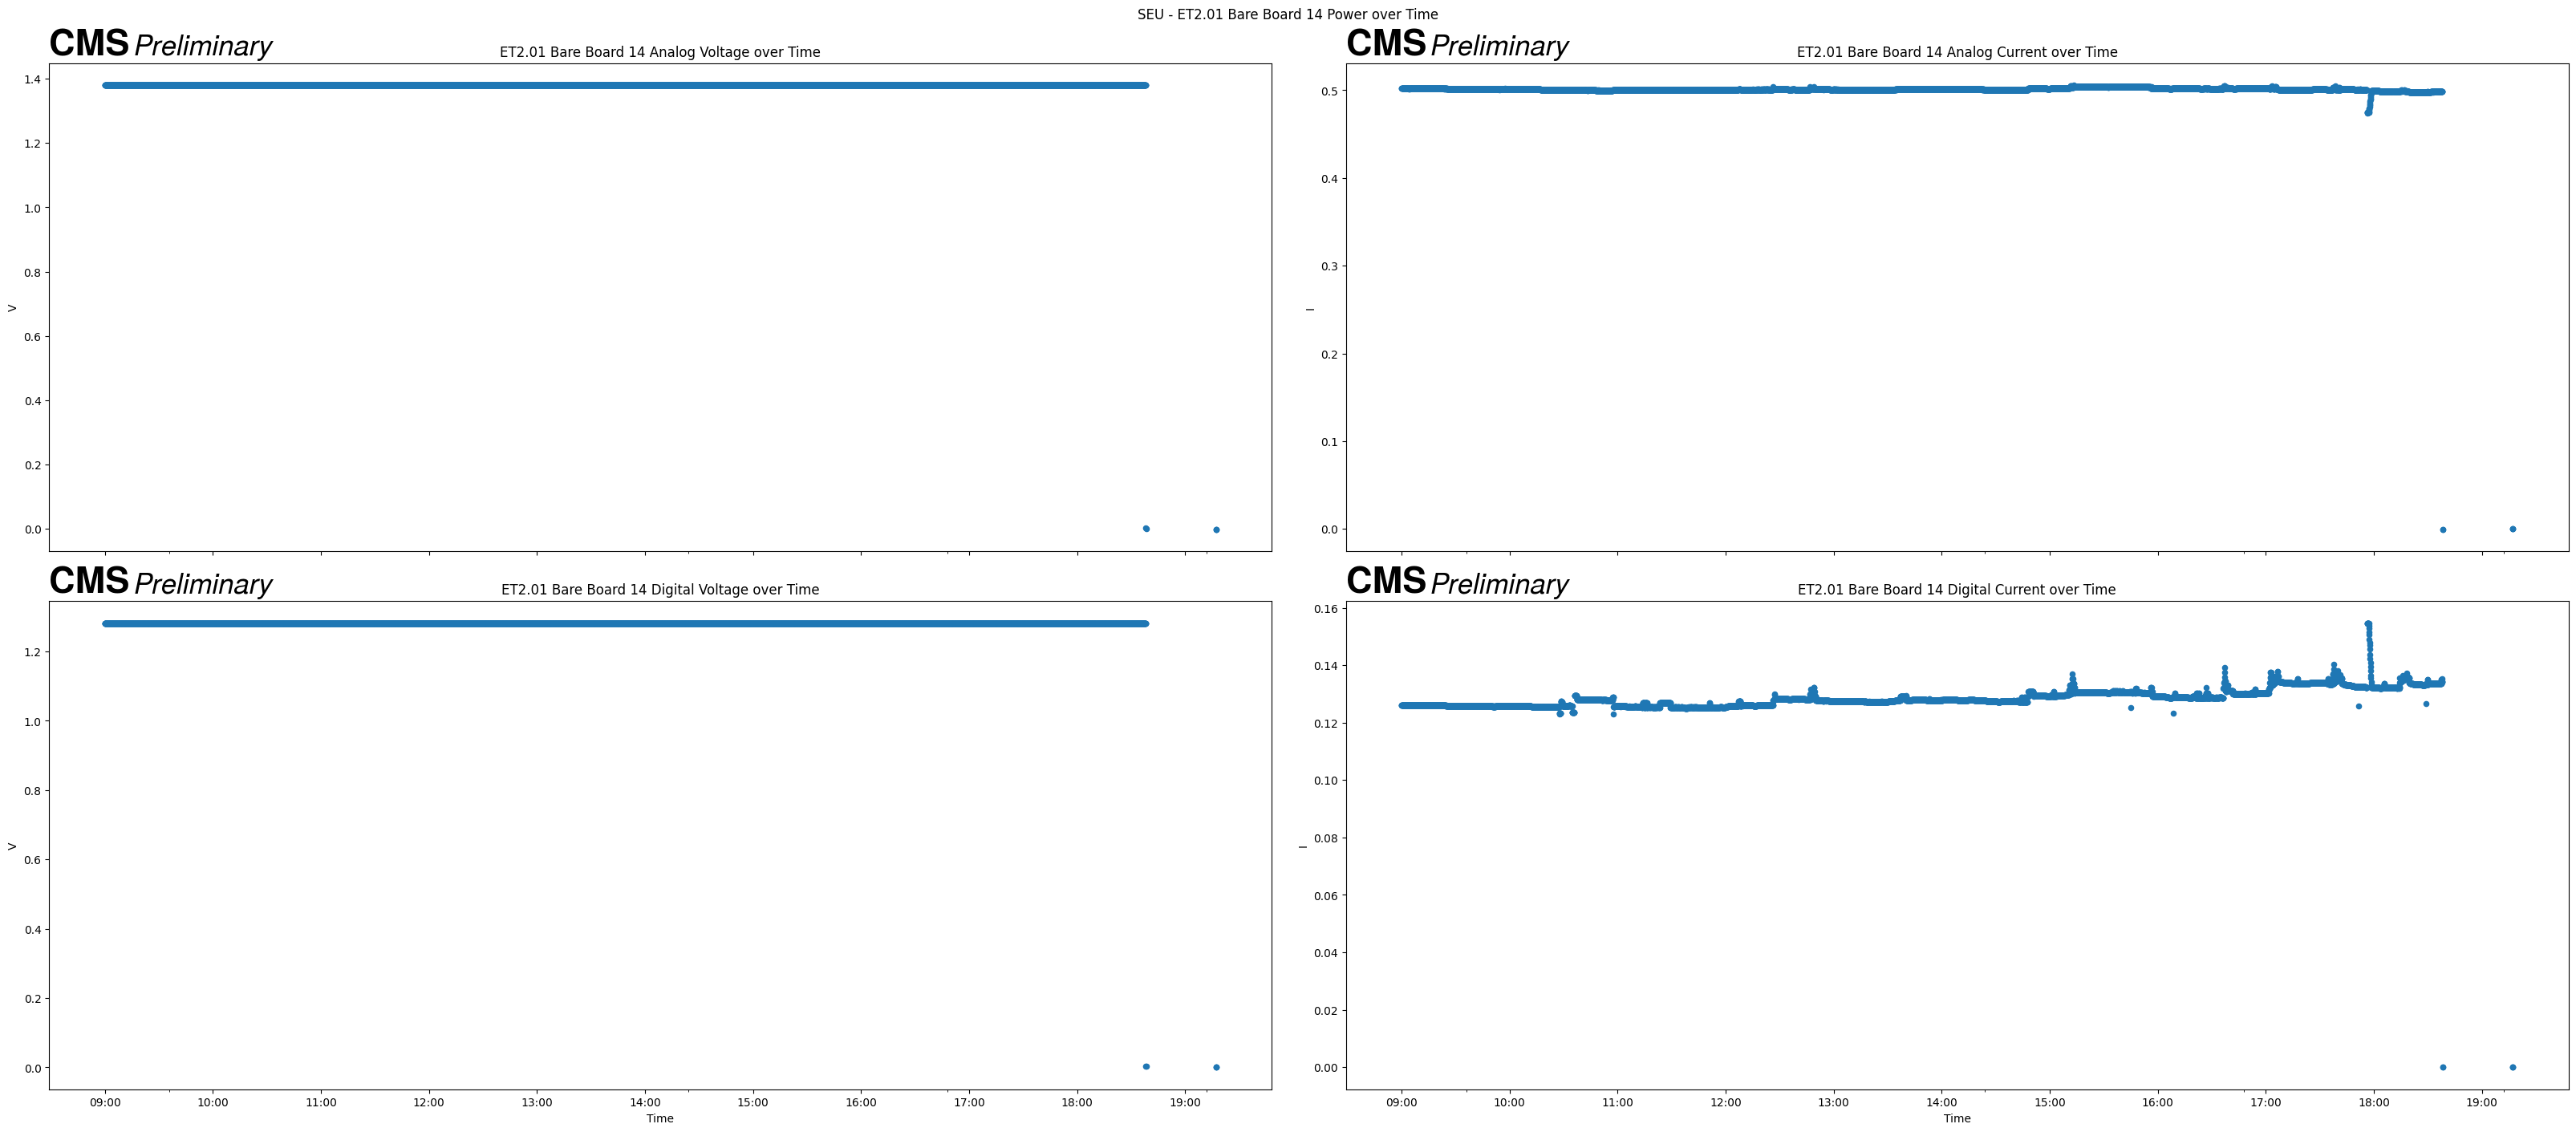

In [5]:
board = "ET2.01 Bare Board 14"
plotBoardPower(board, power_connections[board], data_df, f'SEU - {board} Power over Time', power_directory, True)

In [6]:
# Find time when the SEE happened on the power supply
board = "ET2.01 Bare Board 14"
instrument, channel = power_connections[board]["Digital"].split(':')
see_df = data_df.loc[(data_df['Instrument'] == instrument) & (data_df['Channel'] == channel)].copy()
ps_see_time = see_df.loc[see_df["V"] > 0.5]["Time"].max()

print(f'The SEE hapened on the power supply at {ps_see_time}')

The SEE hapened on the power supply at 2024-05-11 18:38:02.217221


## ET2.1 Bare 11

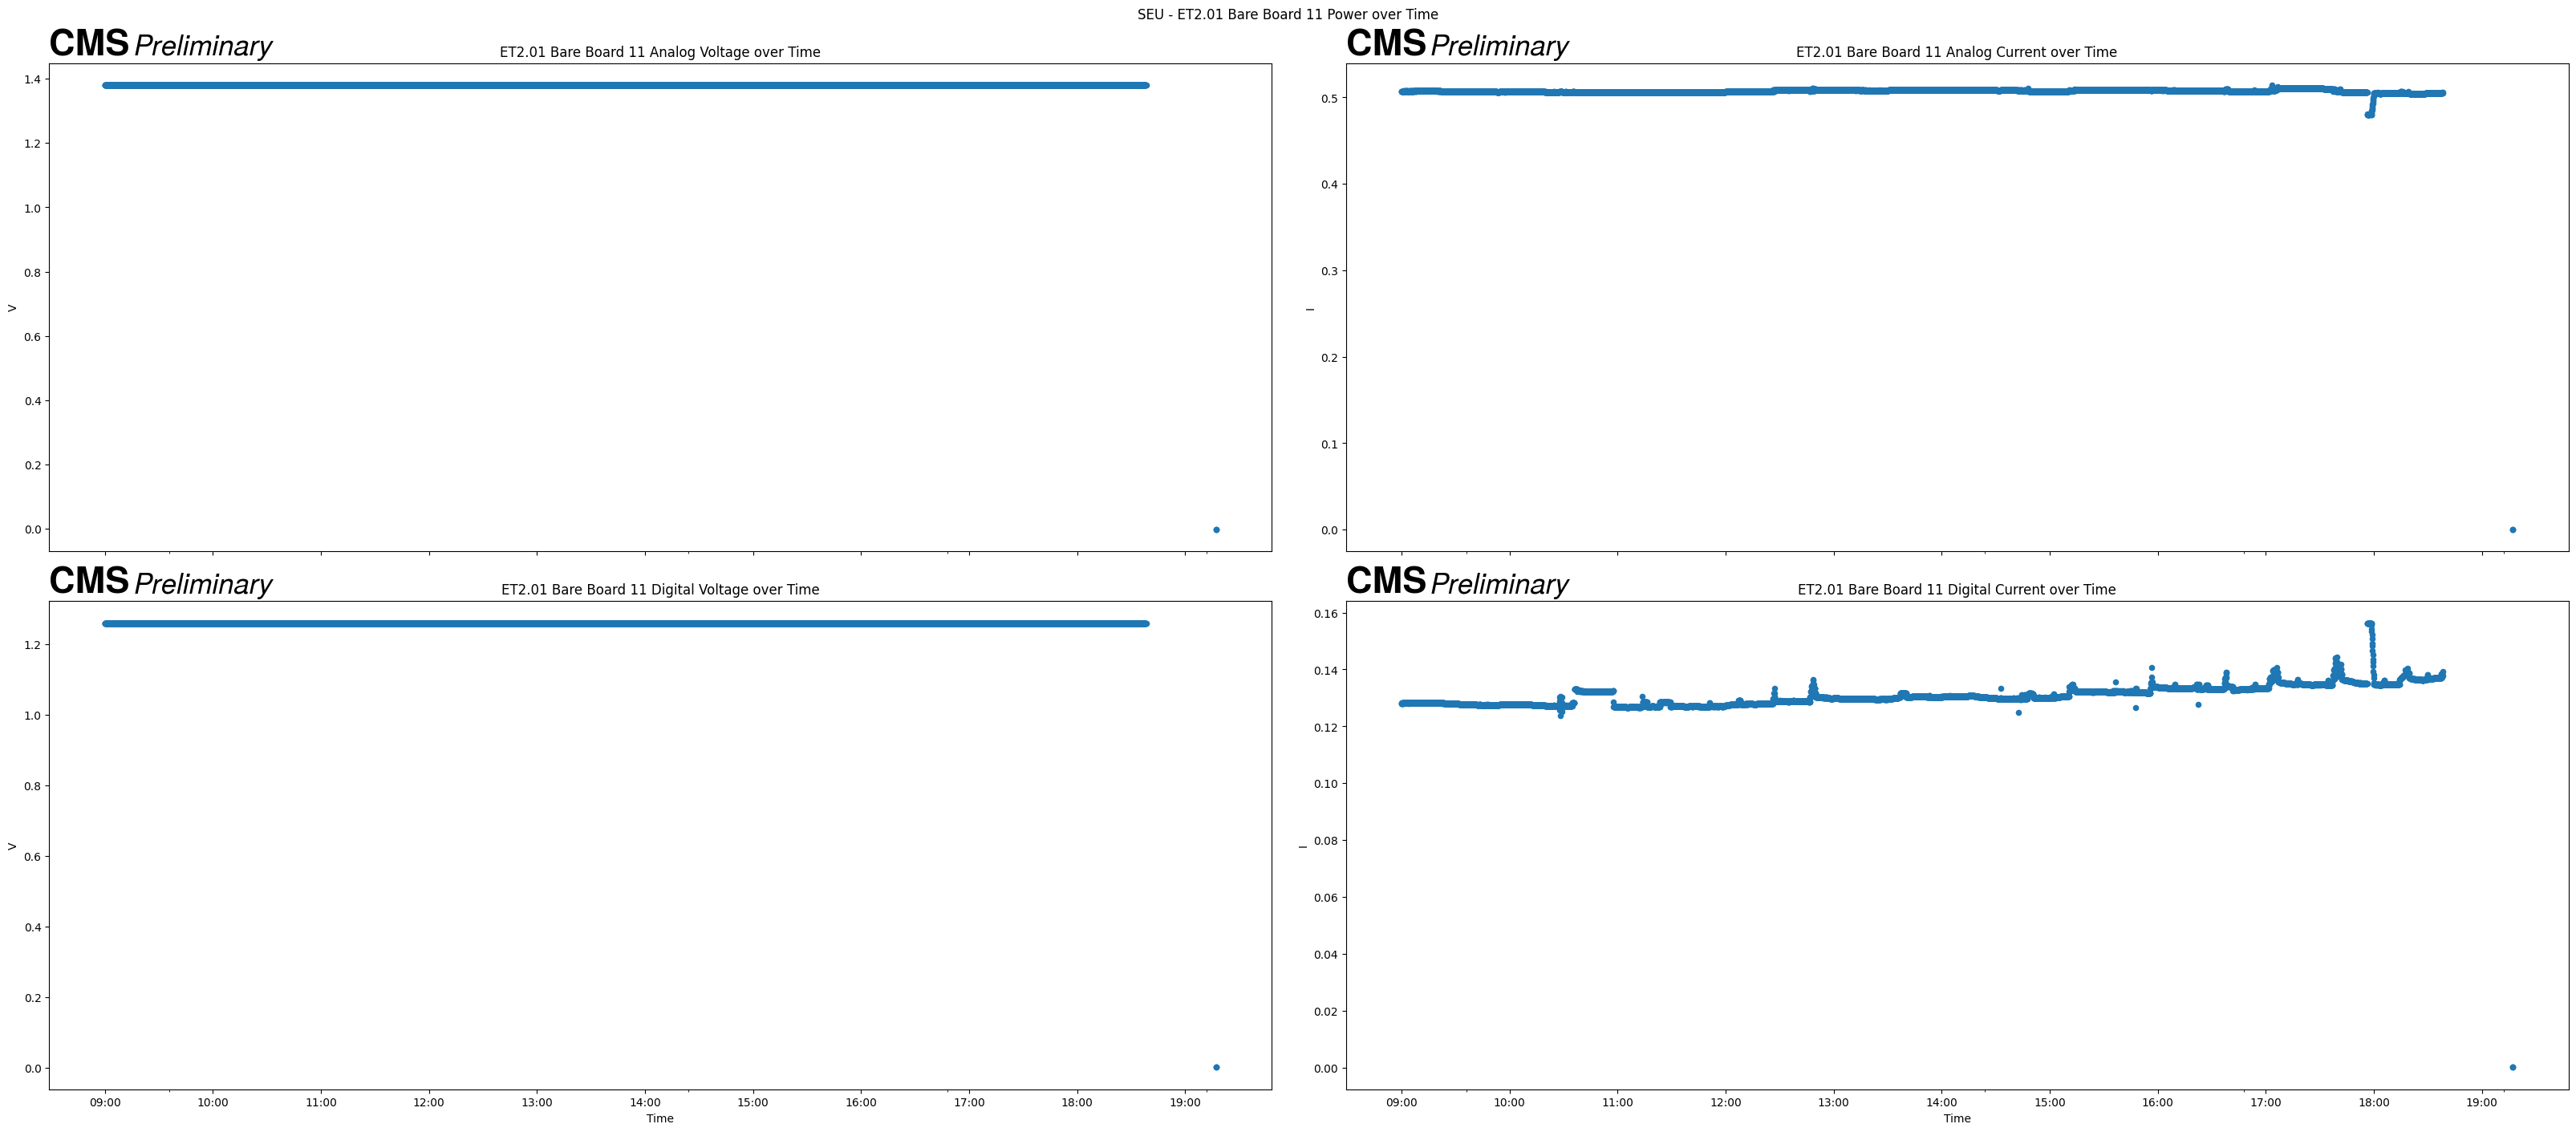

In [7]:
board = "ET2.01 Bare Board 11"
plotBoardPower(board, power_connections[board], data_df, f'SEU - {board} Power over Time', power_directory, True)

## ET2.1 Bare 15

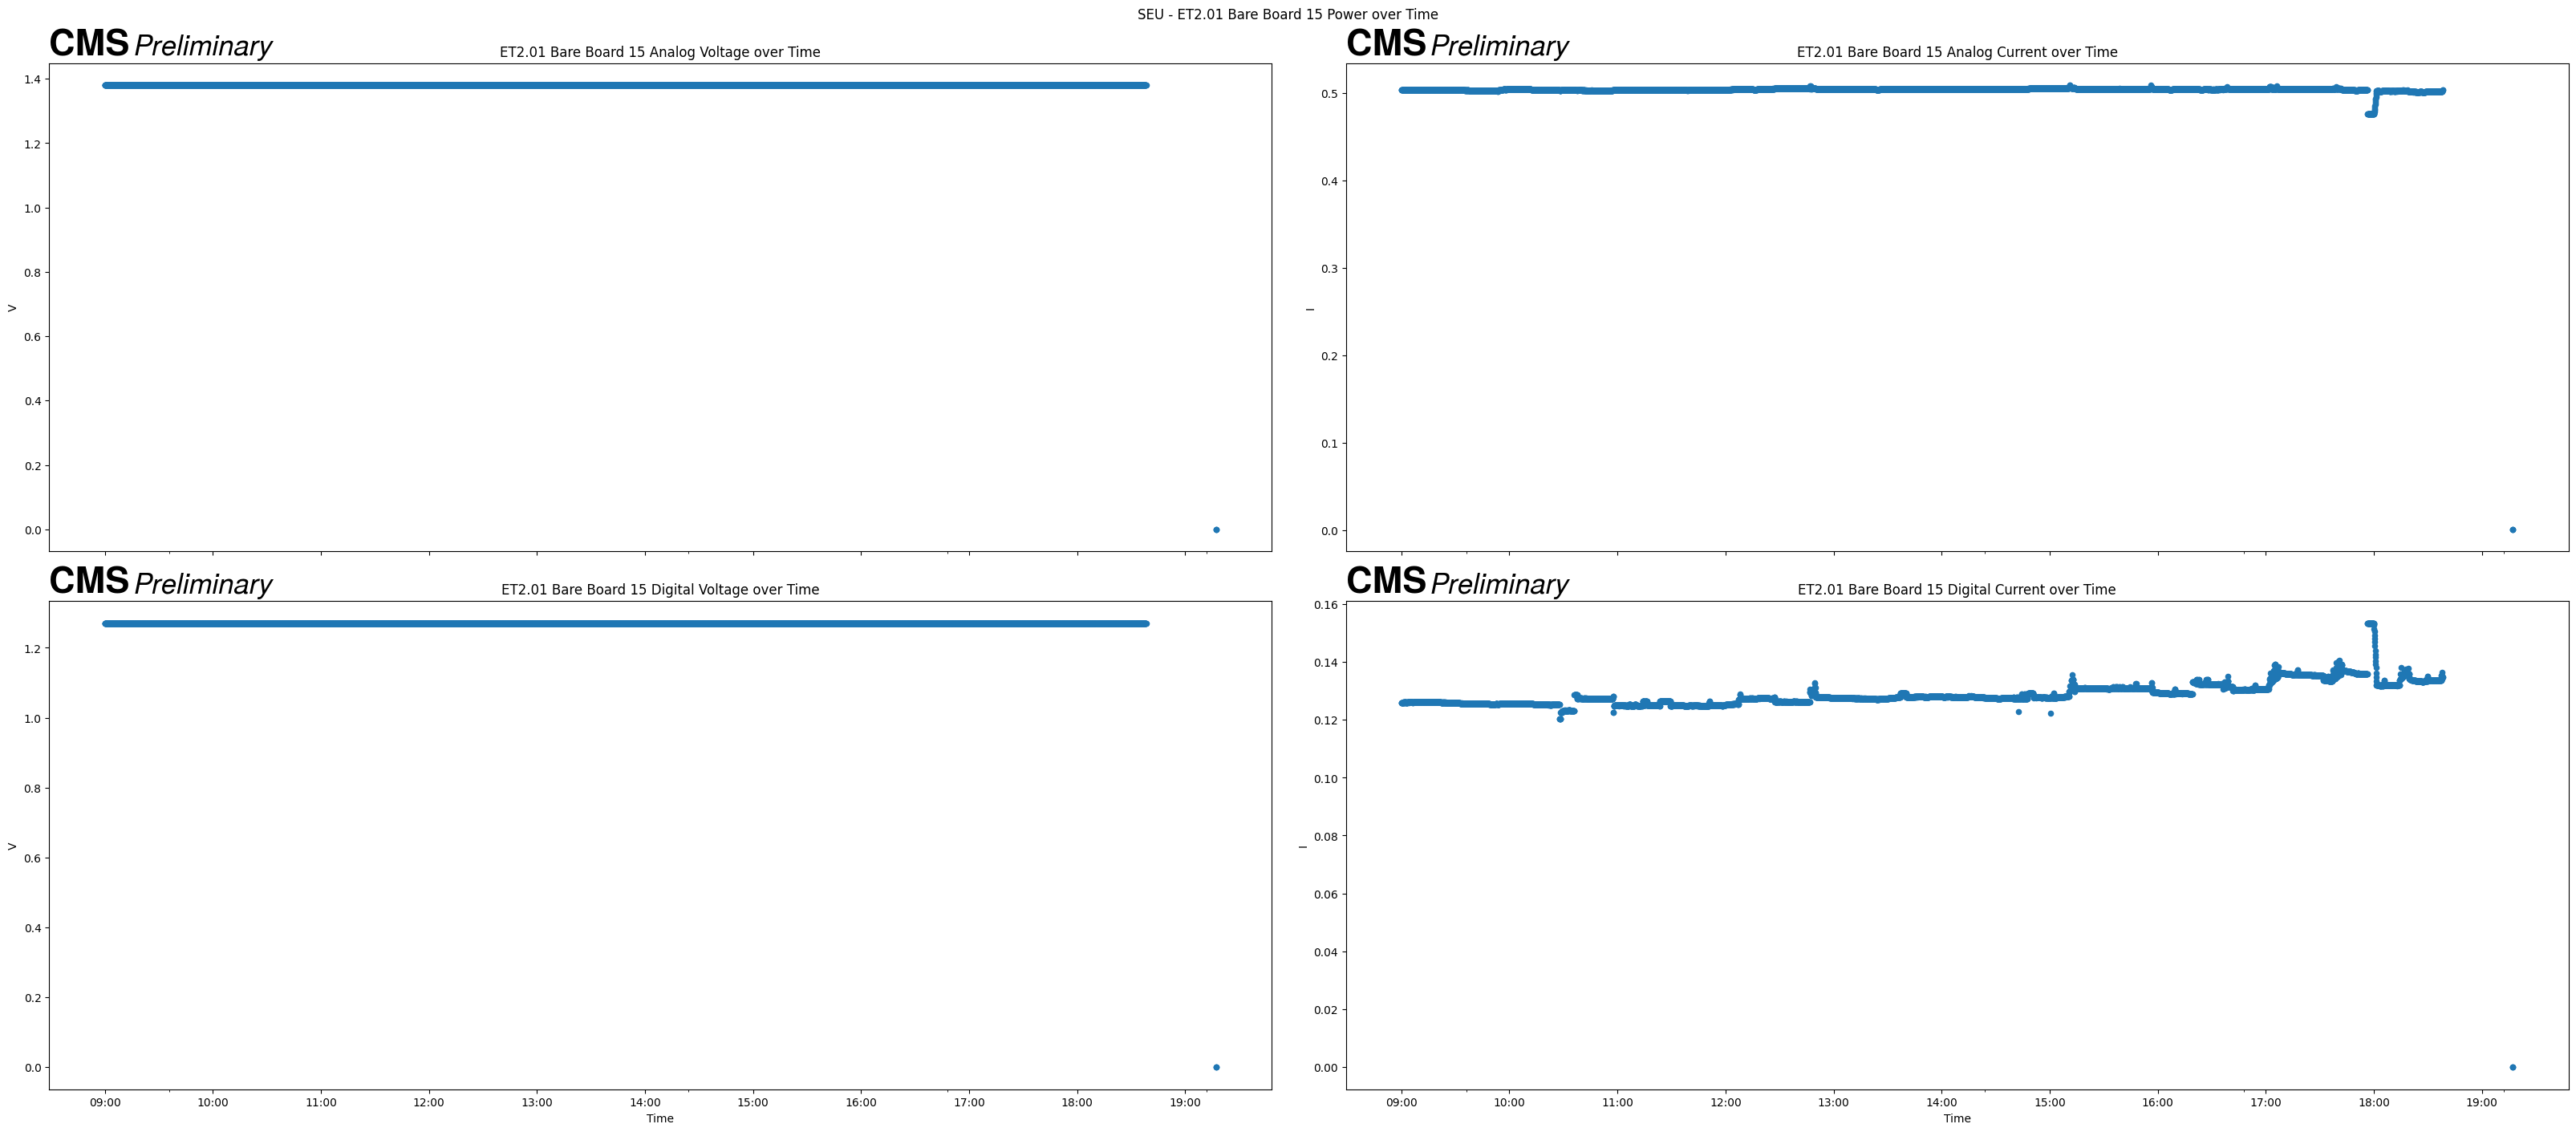

In [8]:
board = "ET2.01 Bare Board 15"
plotBoardPower(board, power_connections[board], data_df, f'SEU - {board} Power over Time', power_directory, True)

## ET2.1 Bare 12

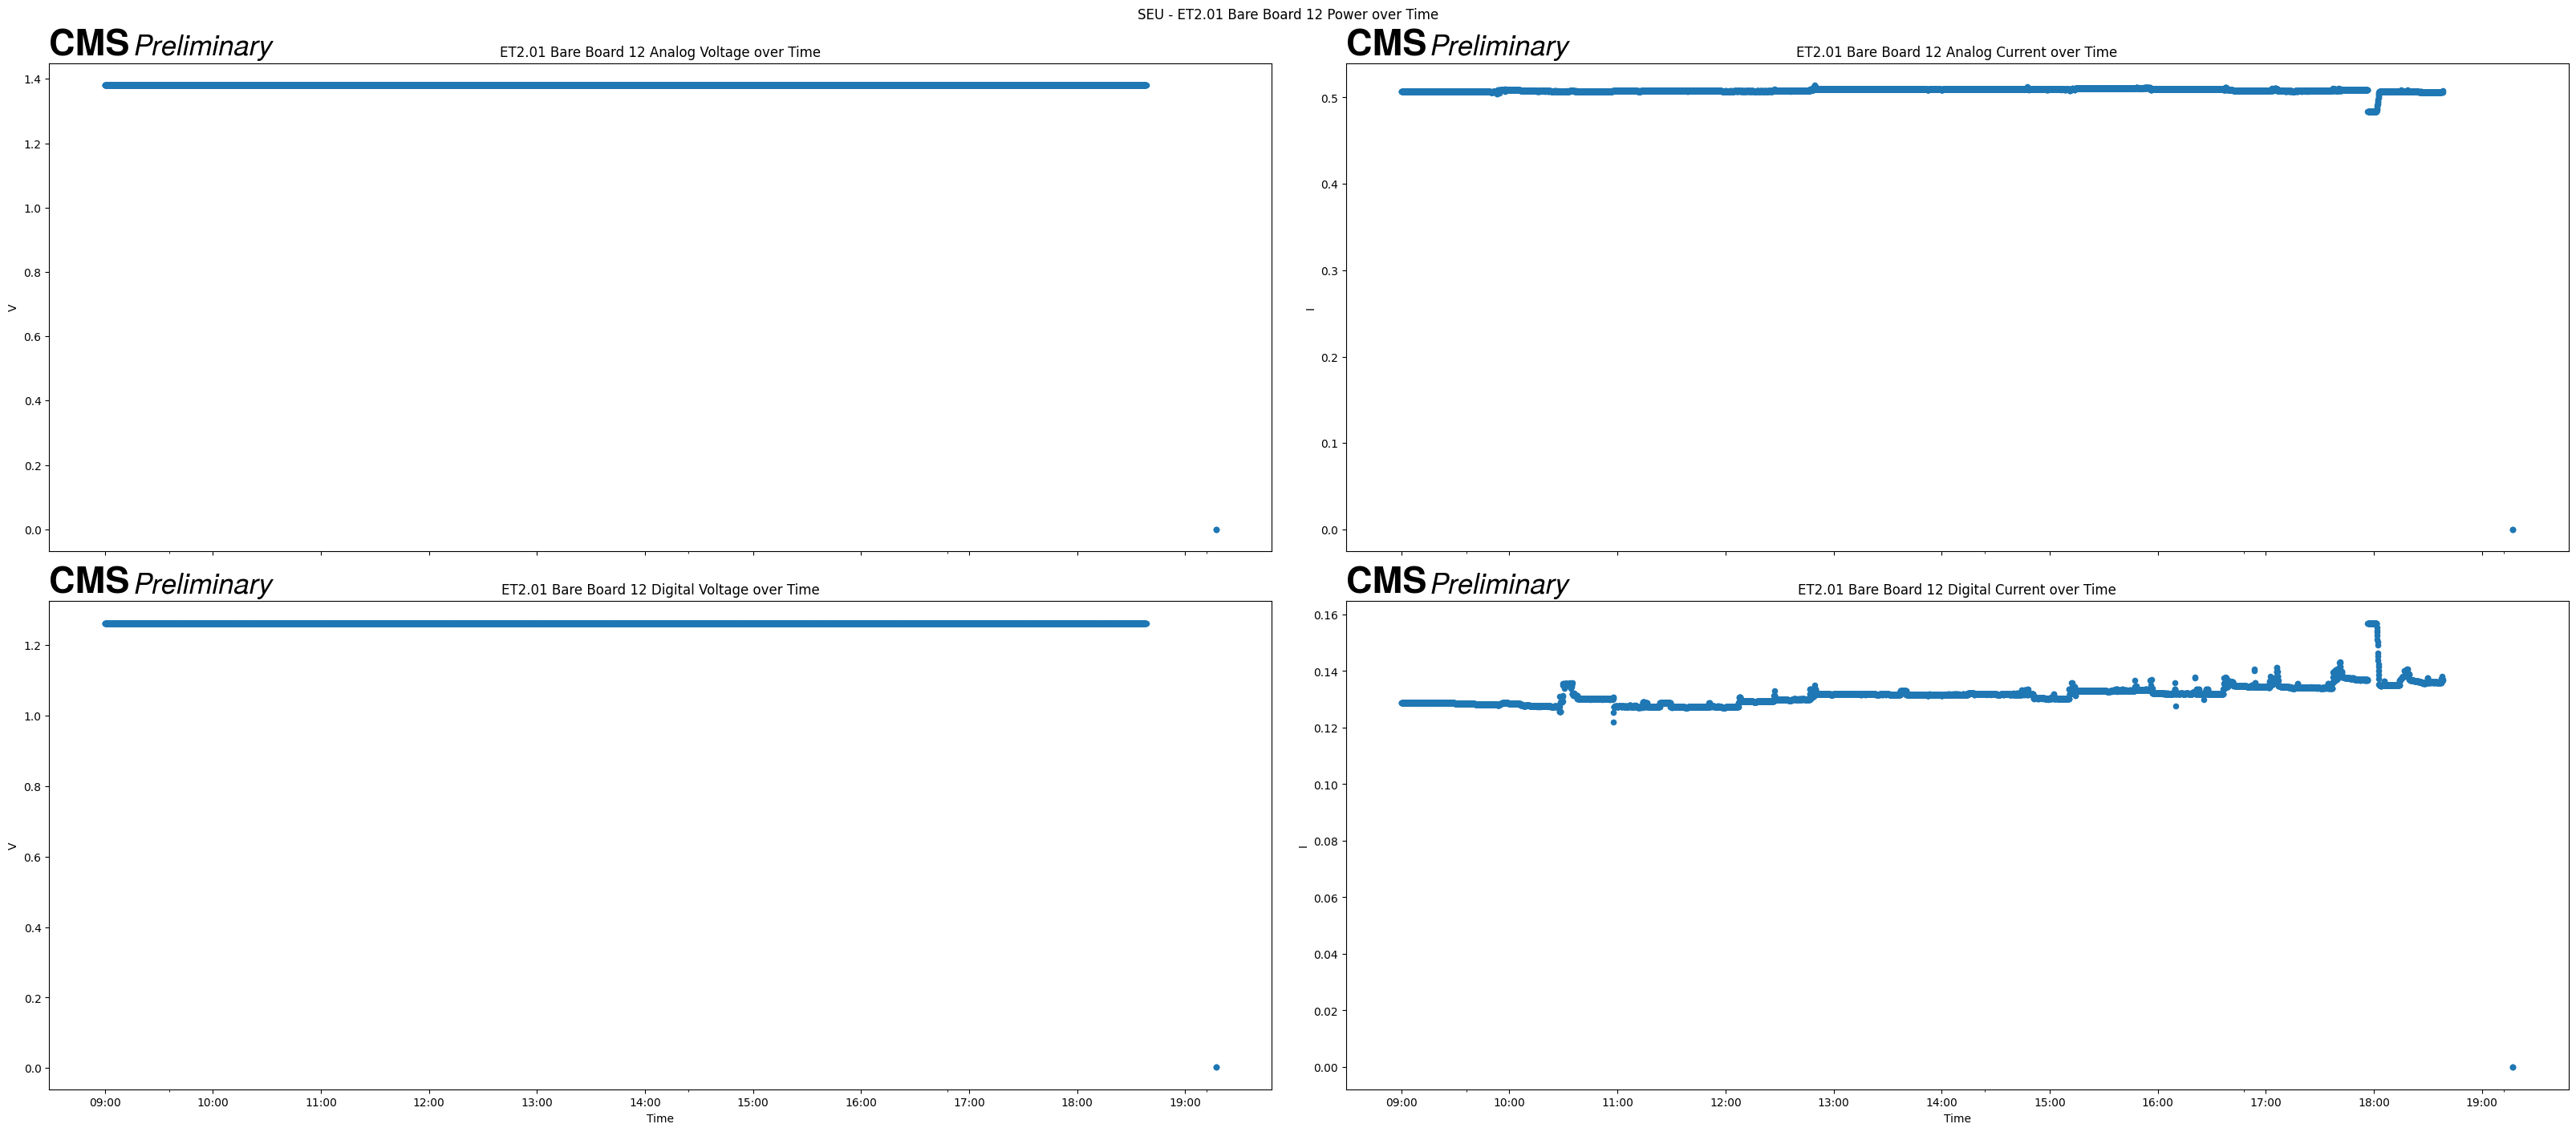

In [9]:
board = "ET2.01 Bare Board 12"
plotBoardPower(board, power_connections[board], data_df, f'SEU - {board} Power over Time', power_directory, True)

## Waveform Sampler

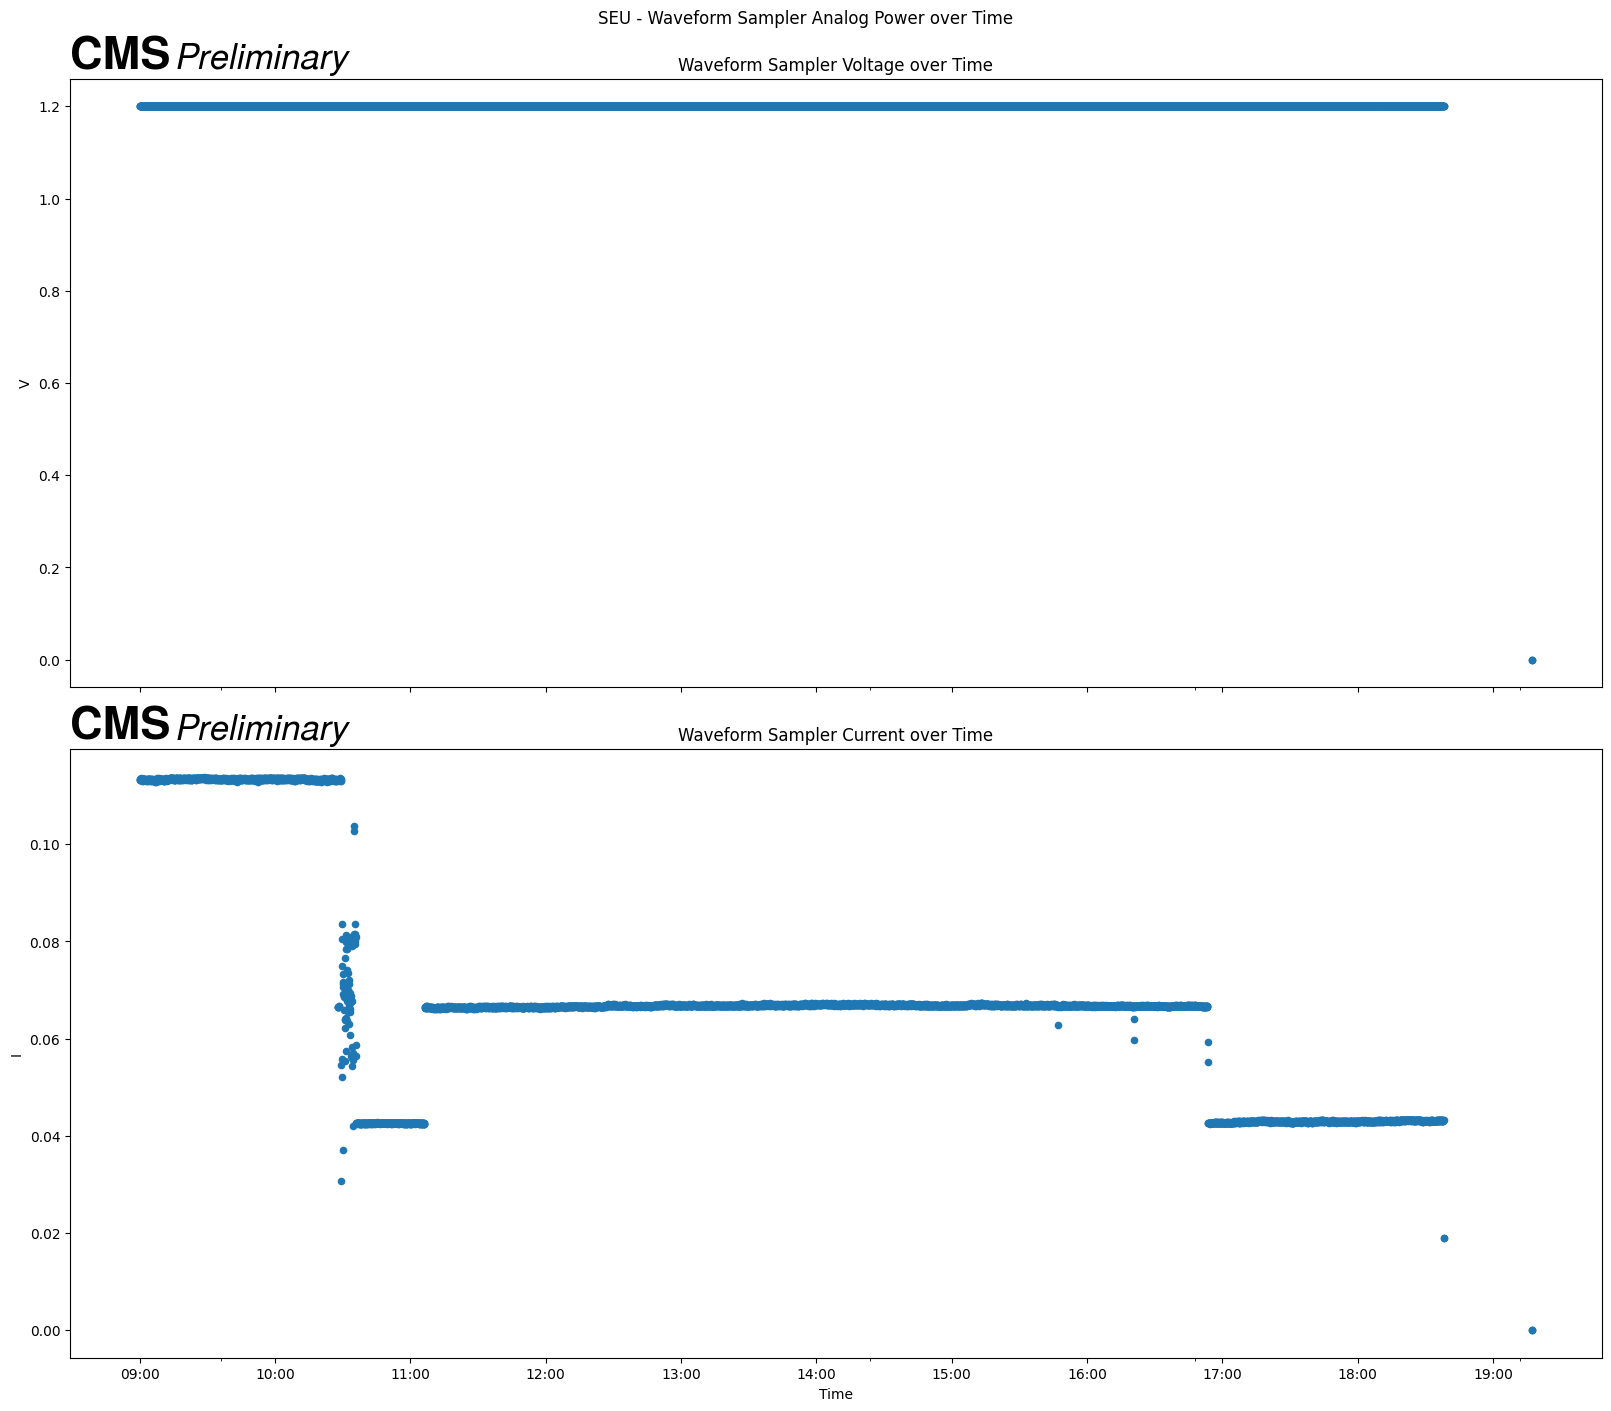

In [10]:
plotWSPower(wsana_df, 'SEU - Waveform Sampler Analog Power over Time', power_directory, True, filename = "WaveformSamplerAnalog")

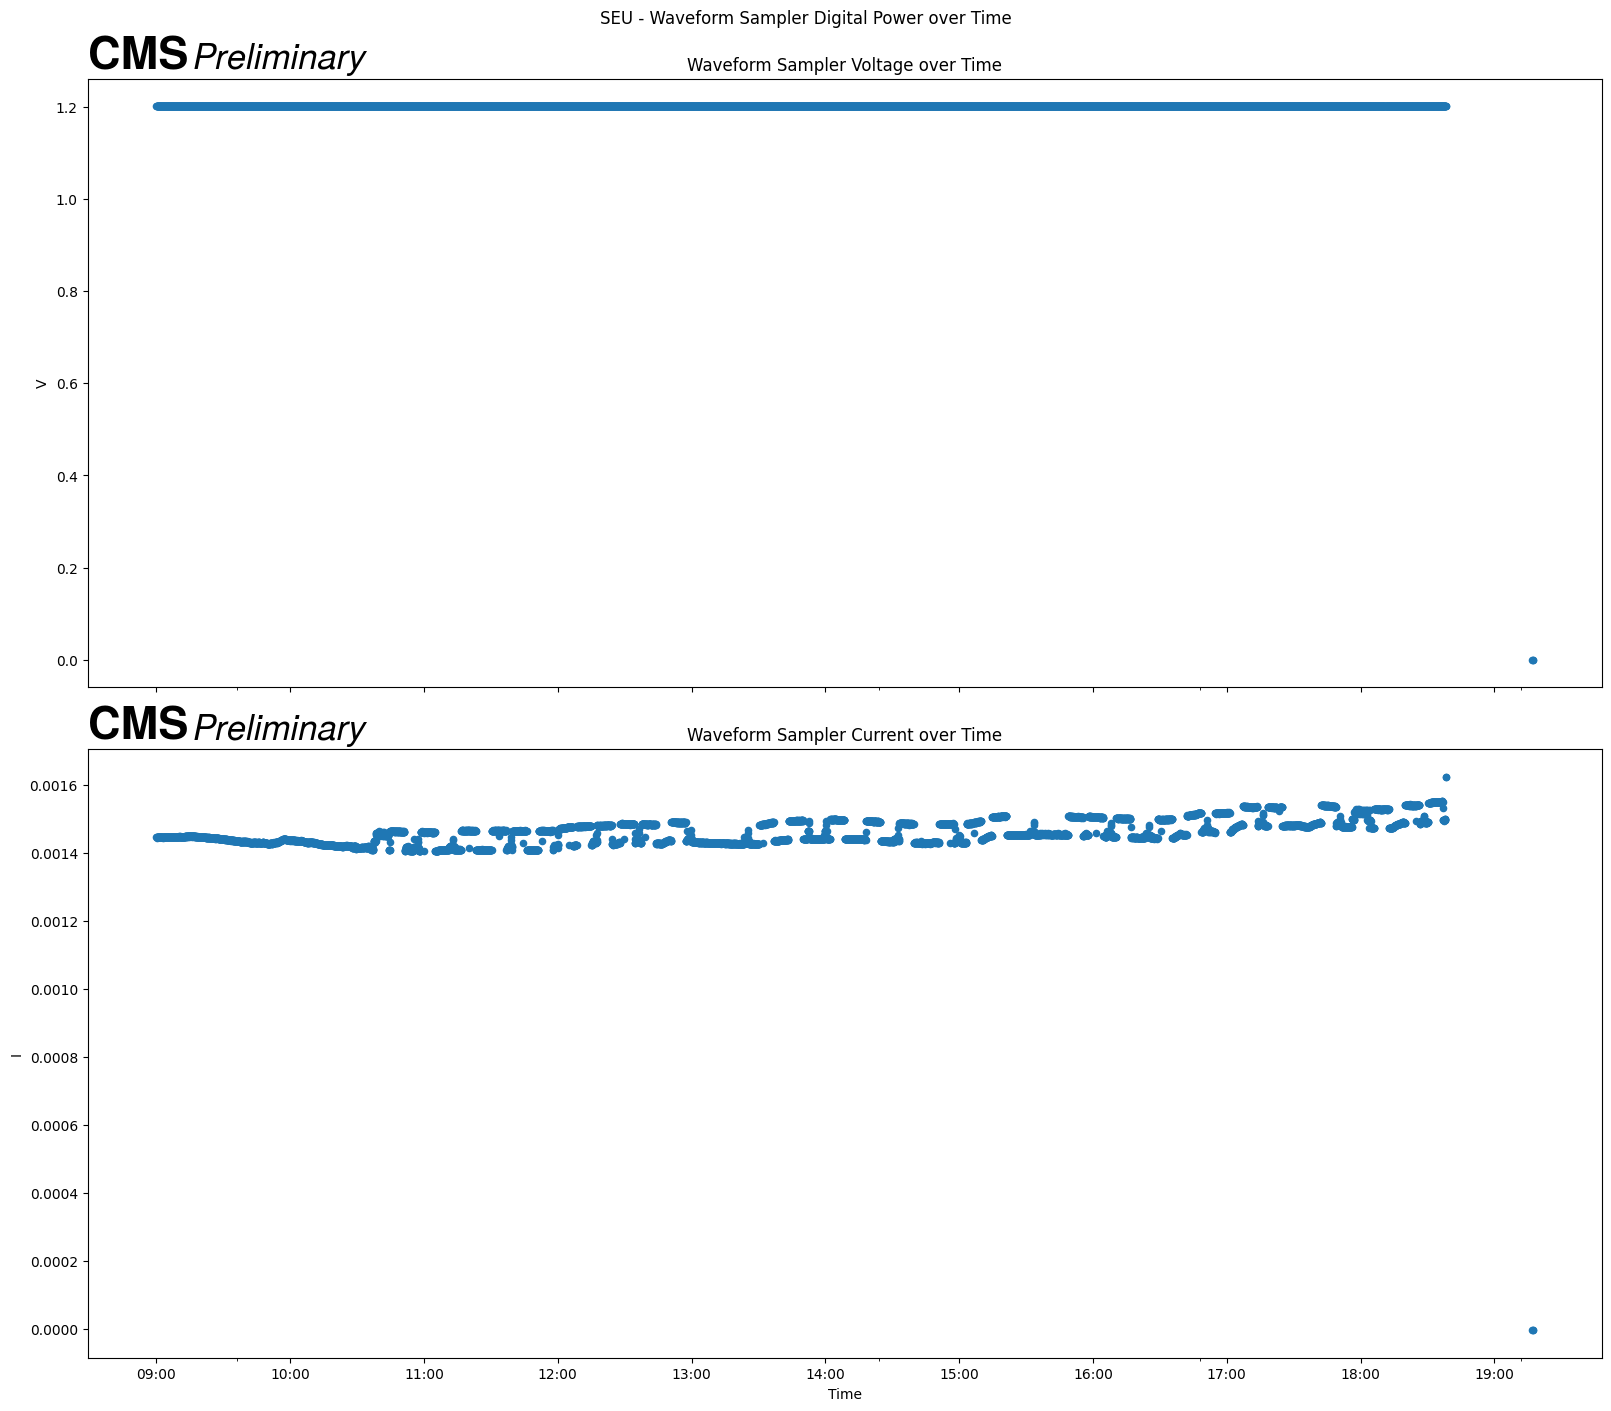

In [11]:
plotWSPower(wsdig_df, 'SEU - Waveform Sampler Digital Power over Time', power_directory, True, filename = "WaveformSamplerDigital")

## Per Run Plotting

In [12]:
run_power_dir = power_directory/"PerRun"
run_power_dir.mkdir(exist_ok=True)

plot_only = None

for run_idx_to_plot in range(len(run_info)):
    if plot_only is not None:
        if run_idx_to_plot < plot_only - 1:
            continue
        if run_idx_to_plot == plot_only:
            break
    if run_idx_to_plot == 0:
        makePerRunPlots(
            data_df,
            run_info[run_idx_to_plot],
            run_power_dir,
            power_connections,
            extra_run_info = extra_run_info,
            test_run_info = test_run_info,
        )
    else:
        makePerRunPlots(
            data_df,
            run_info[run_idx_to_plot],
            run_power_dir,
            power_connections,
            previous_run_info = run_info[run_idx_to_plot - 1],
            extra_run_info = extra_run_info,
            test_run_info = test_run_info,
        )

for this_run_info in extra_run_info:
    break
    makePerRunPlots(
        data_df,
        this_run_info,
        run_power_dir,
        power_connections,
        all_run_info = run_info,
        extra_run_info = extra_run_info,
        test_run_info = test_run_info,
    )


/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/SEU/SEUhelper.py:108: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure, axis = plt.subplots(


<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 1600x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

<Figure size 3200x1400 with 0 Axes>

# Baseline History

In [13]:
baseline_history_file = base_directory/"ETROC-History"/"BaselineHistory.sqlite"
baseline_directory = output_dir/"Baselines"
baseline_directory.mkdir(exist_ok=True)

col_list = [8, 2, 8, 2]
row_list = [0, 0, 2, 2]
scan_list = list(zip(row_list, col_list))
chip_df = {}

times_to_plot = {
}

with sqlite3.connect(baseline_history_file) as sqlite3_connection:
    baseline_df = pandas.read_sql('SELECT * FROM baselines', sqlite3_connection, index_col=None)
    baseline_df['Time'] = pandas.to_datetime(baseline_df['timestamp'], format='mixed')

    # Remove data that is outside the range of the campaign
    baseline_df = baseline_df.loc[baseline_df['Time'] >= (start_time - datetime.timedelta(minutes=12))]
    baseline_df = baseline_df.loc[baseline_df['Time'] <= end_time].copy()

    for chip_name in chip_names:
        chip_df[chip_name] = baseline_df.loc[baseline_df["chip_name"] == chip_name].copy()

        plotPixelsOverTime(chip_df[chip_name], 'baseline', f"Baselines of {chip_name.replace("_", " ")}", scan_list, baseline_directory/f"{chip_name}_Baseline.pdf", times_to_plot = times_to_plot)
        plotPixelsOverTime(chip_df[chip_name], 'noise_width', f"Noise Widths of {chip_name.replace("_", " ")}", scan_list, baseline_directory/f"{chip_name}_NoiseWidth.pdf", times_to_plot = times_to_plot)


<Figure size 1600x700 with 0 Axes>

<Figure size 1600x700 with 0 Axes>

<Figure size 1600x700 with 0 Axes>

<Figure size 1600x700 with 0 Axes>

<Figure size 1600x700 with 0 Axes>

<Figure size 1600x700 with 0 Axes>

<Figure size 1600x700 with 0 Axes>

<Figure size 1600x700 with 0 Axes>

# I2C Config

In [14]:
import pickle
import numpy
import copy
import tempfile
import shutil

from math import ceil

config_compare_dir = output_dir/"I2CConfiguration"
config_compare_dir.mkdir(exist_ok=True)
base_config_compare_dir = config_compare_dir

base_bitmap = {
}
for idx in range(32):
    base_bitmap[f'PeriCfg{idx}']  = [0 for _ in range(8)]
for idx in range(16):
    base_bitmap[f'PeriStat{idx}'] = [0 for _ in range(8)]
for idx in range(32):
    base_bitmap[f'PixCfg{idx}']   = [0 for _ in range(8)]
for idx in range(8):
    base_bitmap[f'PixStat{idx}']  = [0 for _ in range(8)]

## Optional run_info filtering
In order to only process a few runs

In [24]:
## Filter run info
run_info = []

for run in run_info_backup:
    if run["fluence_type"] is not None:
        continue
    run_info.append(run)

extra_file_name = "BeamOff"

config_compare_dir = base_config_compare_dir/extra_file_name
config_compare_dir.mkdir(exist_ok=True)

print(run_info)
for info in run_info:
    print(f'  {info["name"]}')

[{'name': 'Run_May11SEU_1', 'start': datetime.datetime(2024, 5, 11, 11, 6, 17), 'stop': datetime.datetime(2024, 5, 11, 11, 10, 53), 'boards': ['ET2.01 Bare Board 14', 'ET2.01 Bare Board 11', 'ET2.01 Bare Board 15', 'ET2.01 Bare Board 12'], 'board_channels': [0, 1, 2, 3], 'pre_config_times': [datetime.datetime(2024, 5, 11, 11, 0, 2), datetime.datetime(2024, 5, 11, 11, 1, 41), datetime.datetime(2024, 5, 11, 11, 3, 18), datetime.datetime(2024, 5, 11, 11, 4, 56)], 'post_config_times': [None, None, None, None], 'config_before': True, 'fluence': 0, 'fluence_type': None, 'pixel_TMR': 'off'}, {'name': 'Run_May11SEU_2', 'start': datetime.datetime(2024, 5, 11, 11, 23, 27), 'stop': datetime.datetime(2024, 5, 11, 11, 29, 32), 'boards': ['ET2.01 Bare Board 14', 'ET2.01 Bare Board 11', 'ET2.01 Bare Board 15', 'ET2.01 Bare Board 12'], 'board_channels': [0, 1, 2, 3], 'pre_config_times': [datetime.datetime(2024, 5, 11, 11, 18, 19), datetime.datetime(2024, 5, 11, 11, 19, 57), datetime.datetime(2024, 5, 

In [26]:
## Filter run info
run_info = []

for run in run_info_backup:
    if run["fluence_type"] is None:
        continue
    run_info.append(run)

extra_file_name = "BeamOn"

config_compare_dir = base_config_compare_dir/extra_file_name
config_compare_dir.mkdir(exist_ok=True)

print(run_info)
for info in run_info:
    print(f'  {info["name"]}')

[{'name': 'Run_May11SEU_3', 'start': datetime.datetime(2024, 5, 11, 11, 50, 50), 'stop': datetime.datetime(2024, 5, 11, 11, 51, 11), 'boards': ['ET2.01 Bare Board 14', 'ET2.01 Bare Board 11', 'ET2.01 Bare Board 15', 'ET2.01 Bare Board 12'], 'board_channels': [0, 1, 2, 3], 'pre_config_times': [datetime.datetime(2024, 5, 11, 11, 41, 11), datetime.datetime(2024, 5, 11, 11, 42, 49), datetime.datetime(2024, 5, 11, 11, 44, 27), datetime.datetime(2024, 5, 11, 11, 46, 5)], 'post_config_times': [datetime.datetime(2024, 5, 11, 11, 52, 58), datetime.datetime(2024, 5, 11, 11, 54, 36), datetime.datetime(2024, 5, 11, 11, 56, 14), datetime.datetime(2024, 5, 11, 11, 57, 52)], 'config_before': True, 'fluence': 39900000000.0, 'fluence_type': 'p', 'pixel_TMR': 'off'}, {'name': 'Run_May11SEU_4', 'start': datetime.datetime(2024, 5, 11, 12, 7, 10), 'stop': datetime.datetime(2024, 5, 11, 12, 8, 21), 'boards': ['ET2.01 Bare Board 14', 'ET2.01 Bare Board 11', 'ET2.01 Bare Board 15', 'ET2.01 Bare Board 12'], 'b

In [31]:
## Filter run info
run_info = []

for run in run_info_backup:
    if run["fluence_type"] is None:
        continue
    if run["pixel_TMR"] != "off":
        continue
    run_info.append(run)

extra_file_name = "TMROff"

config_compare_dir = base_config_compare_dir/extra_file_name
config_compare_dir.mkdir(exist_ok=True)

print(run_info)
for info in run_info:
    print(f'  {info["name"]}')

[{'name': 'Run_May11SEU_3', 'start': datetime.datetime(2024, 5, 11, 11, 50, 50), 'stop': datetime.datetime(2024, 5, 11, 11, 51, 11), 'boards': ['ET2.01 Bare Board 14', 'ET2.01 Bare Board 11', 'ET2.01 Bare Board 15', 'ET2.01 Bare Board 12'], 'board_channels': [0, 1, 2, 3], 'pre_config_times': [datetime.datetime(2024, 5, 11, 11, 41, 11), datetime.datetime(2024, 5, 11, 11, 42, 49), datetime.datetime(2024, 5, 11, 11, 44, 27), datetime.datetime(2024, 5, 11, 11, 46, 5)], 'post_config_times': [datetime.datetime(2024, 5, 11, 11, 52, 58), datetime.datetime(2024, 5, 11, 11, 54, 36), datetime.datetime(2024, 5, 11, 11, 56, 14), datetime.datetime(2024, 5, 11, 11, 57, 52)], 'config_before': True, 'fluence': 39900000000.0, 'fluence_type': 'p', 'pixel_TMR': 'off'}, {'name': 'Run_May11SEU_4', 'start': datetime.datetime(2024, 5, 11, 12, 7, 10), 'stop': datetime.datetime(2024, 5, 11, 12, 8, 21), 'boards': ['ET2.01 Bare Board 14', 'ET2.01 Bare Board 11', 'ET2.01 Bare Board 15', 'ET2.01 Bare Board 12'], 'b

In [33]:
## Filter run info
run_info = []

for run in run_info_backup:
    if run["fluence_type"] is None:
        continue
    if run["pixel_TMR"] != "on":
        continue
    run_info.append(run)

extra_file_name = "TMROn"

config_compare_dir = base_config_compare_dir/extra_file_name
config_compare_dir.mkdir(exist_ok=True)

print(run_info)
for info in run_info:
    print(f'  {info["name"]}')

[{'name': 'Run_May11SEU_16', 'start': datetime.datetime(2024, 5, 11, 18, 14, 15), 'stop': datetime.datetime(2024, 5, 11, 18, 19, 41), 'boards': ['ET2.01 Bare Board 14', 'ET2.01 Bare Board 11', 'ET2.01 Bare Board 15', 'ET2.01 Bare Board 12'], 'board_channels': [0, 1, 2, 3], 'pre_config_times': [datetime.datetime(2024, 5, 11, 18, 7, 46), datetime.datetime(2024, 5, 11, 18, 9, 24), datetime.datetime(2024, 5, 11, 18, 11, 3), datetime.datetime(2024, 5, 11, 18, 12, 41)], 'post_config_times': [datetime.datetime(2024, 5, 11, 18, 21, 33), datetime.datetime(2024, 5, 11, 18, 23, 11), datetime.datetime(2024, 5, 11, 18, 24, 49), datetime.datetime(2024, 5, 11, 18, 26, 27)], 'config_before': True, 'fluence': 11700000000000.0, 'fluence_type': 'p', 'pixel_TMR': 'on'}, {'name': 'Run_May11SEU_17', 'start': datetime.datetime(2024, 5, 11, 18, 37, 27), 'stop': datetime.datetime(2024, 5, 11, 18, 43, 54), 'boards': ['ET2.01 Bare Board 14', 'ET2.01 Bare Board 11', 'ET2.01 Bare Board 15', 'ET2.01 Bare Board 12']

In [35]:
## Filter run info
run_info = []

for run in run_info_backup:
    if run["fluence_type"] is None:
        continue
    if run["pixel_TMR"] != "mixed":
        continue
    run_info.append(run)

extra_file_name = "TMRMixed"

config_compare_dir = base_config_compare_dir/extra_file_name
config_compare_dir.mkdir(exist_ok=True)

print(run_info)
for info in run_info:
    print(f'  {info["name"]}')

[{'name': 'Run_May11SEU_15', 'start': datetime.datetime(2024, 5, 11, 17, 36, 56), 'stop': datetime.datetime(2024, 5, 11, 17, 42, 22), 'boards': ['ET2.01 Bare Board 14', 'ET2.01 Bare Board 11', 'ET2.01 Bare Board 15', 'ET2.01 Bare Board 12'], 'board_channels': [0, 1, 2, 3], 'pre_config_times': [datetime.datetime(2024, 5, 11, 17, 19, 58), datetime.datetime(2024, 5, 11, 17, 21, 36), datetime.datetime(2024, 5, 11, 17, 23, 14), datetime.datetime(2024, 5, 11, 17, 24, 52)], 'post_config_times': [datetime.datetime(2024, 5, 11, 17, 44, 2), datetime.datetime(2024, 5, 11, 17, 45, 40), datetime.datetime(2024, 5, 11, 17, 47, 18), datetime.datetime(2024, 5, 11, 17, 48, 56)], 'config_before': True, 'fluence': 11600000000000.0, 'fluence_type': 'p', 'pixel_TMR': 'mixed'}]
  Run_May11SEU_15


In [15]:
run_info = run_info_backup
extra_file_name = ""
config_compare_dir = base_config_compare_dir

## Do config comparison

In [36]:
accumulated_status_map = {}
accumulated_config_map = {}
accumulated_bitmap = {}

extra_bitmap = {}

counter = 0
for this_run_idx in range(len(run_info)):
    counter += 1
    #if counter == 2:
    #    break
    #if counter < 4:
    #    continue
    this_run_info = run_info[this_run_idx]
    this_run_name = this_run_info["name"]

    this_run_dir = base_config_compare_dir/this_run_name
    this_run_dir.mkdir(exist_ok=True)

    for board_idx in range(len(this_run_info["boards"])):
        board_name = this_run_info["boards"][board_idx]

        if board_name not in accumulated_bitmap:
            accumulated_bitmap[board_name] = copy.deepcopy(base_bitmap)

        pre_config_time  = this_run_info[ "pre_config_times"][board_idx]
        post_config_time = this_run_info["post_config_times"][board_idx]

        if post_config_time is None:
            print(f'No post config time for board {board_name} for run {this_run_name}')
            continue

        if pre_config_time is None:
            if "config_before" in this_run_info and not this_run_info["config_before"]:
                for offset in range(this_run_idx):
                    previous_run_info = run_info[this_run_idx - 1 - offset]

                    previous_board_idx = None
                    for idx in range(len(previous_run_info["boards"])):
                        if board_name == previous_run_info["boards"][idx]:
                            previous_board_idx = idx
                            break

                    if previous_board_idx is None:
                        continue  #  TODO: Perhaps this should be a break

                    pre_config_time = previous_run_info["post_config_times"][previous_board_idx]

                    if pre_config_time is not None:
                        break

                    if "config_before" in previous_run_info and not previous_run_info["config_before"]:
                        continue
                    break

            if pre_config_time is None:
                print(f'No pre config time for board {board_name} for run {this_run_name}')
                continue

        pre_time_tag  =  pre_config_time.isoformat().replace(":", "-")
        post_time_tag = post_config_time.isoformat().replace(":", "-")

        pre_time_file  = list(config_directory.glob(f'{pre_time_tag}*'))
        post_time_file = list(config_directory.glob(f'{post_time_tag}*'))
        if len(pre_time_file) == 0:
            print(f"Couldn't find the pre-time configuration file for board {board_name} for run {this_run_name}")
            continue
        if len(post_time_file) == 0:
            print(f"Couldn't find the post-time configuration file for board {board_name} for run {this_run_name}")
            continue
        if len(pre_time_file) > 1:
            print(f"Found too many pre-time configuration files for board {board_name} for run {this_run_name}")
            continue
        if len(post_time_file) > 1:
            print(f"Found too many post-time configuration files for board {board_name} for run {this_run_name}")
            continue
        pre_time_file  =  pre_time_file[0]
        post_time_file = post_time_file[0]

        print(f'{this_run_name} - {board_name}')

        changed_registers = diff_chip_configs(pre_time_file, post_time_file)
        save_changed_config(changed_registers, this_run_dir, f"changedRegisters_{board_name.replace(' ', '_')}")

        status_map, config_map = get_pixel_bitflip_map(changed_registers)
        plot_map(status_map, f"Pixel Status Bit Flips on {board_name} during Run {this_run_name}", 'Bit Flips', this_run_dir/f"{board_name}_Status.pdf")
        plot_map(config_map, f"Pixel Config Bit Flips on {board_name} during Run {this_run_name}", 'Bit Flips', this_run_dir/f"{board_name}_Config.pdf")

        this_bitmap = copy.deepcopy(base_bitmap)
        other_bitmap = {}
        fill_bitmap(changed_registers, this_bitmap, other_bitmap)
        save_bitmap_table(this_bitmap, this_run_dir, f"{board_name}")
        save_bitmap_bitflips(changed_registers, this_run_dir, f"{board_name}")

        for key in other_bitmap:
            if key not in extra_bitmap:
                extra_bitmap[key] = [0 for _ in range(8)]
            for idx in range(8):
                extra_bitmap[key][idx] += other_bitmap[key][idx]
        for key in this_bitmap:
            for idx in range(8):
                accumulated_bitmap[board_name][key][idx] += this_bitmap[key][idx]

        if board_name not in accumulated_status_map:
            accumulated_status_map[board_name] = status_map
        else:
            for row in range(16):
                for col in range(16):
                    accumulated_status_map[board_name][row][col] += status_map[row][col]
        if board_name not in accumulated_config_map:
            accumulated_config_map[board_name] = config_map
        else:
            for row in range(16):
                for col in range(16):
                    accumulated_config_map[board_name][row][col] += config_map[row][col]

#print(extra_bitmap)
#print(accumulated_bitmap)

if len(extra_bitmap) != 0:
    with open(config_compare_dir/("extra_registers_bitflips.pickle"), "wb") as file:
        pickle.dump(extra_bitmap, file)

    with open(config_compare_dir/("extra_registers_bitflips.txt"), "w") as file:
        file.write("The bits in unnamed registers saw the following amount of bit flips:")
        for register in extra_bitmap:
            file.write(f" - {register}: {extra_bitmap[register]}")

total_bitmap = copy.deepcopy(base_bitmap)
for board_name in accumulated_bitmap:
    save_bitmap_table(accumulated_bitmap[board_name], config_compare_dir, f"{board_name}")
    for key in accumulated_bitmap[board_name]:
        for idx in range(8):
            total_bitmap[key][idx] += accumulated_bitmap[board_name][key][idx]
save_bitmap_table(total_bitmap, config_compare_dir, "Total")

for board_name in accumulated_status_map:
    plot_map(accumulated_status_map[board_name], f"Pixel Status Bit Flips on {board_name} over all Runs", 'Bit Flips', config_compare_dir/f"{board_name}_Status.pdf")
for board_name in accumulated_config_map:
    plot_map(accumulated_config_map[board_name], f"Pixel Config Bit Flips on {board_name} over all Runs", 'Bit Flips', config_compare_dir/f"{board_name}_Config.pdf")


Run_May11SEU_15 - ET2.01 Bare Board 14
Run_May11SEU_15 - ET2.01 Bare Board 11
Run_May11SEU_15 - ET2.01 Bare Board 15
Run_May11SEU_15 - ET2.01 Bare Board 12


## Do the Joined Config analysis

In [17]:
for ion in joined_config_analysis:
    dir_name = f"{ion}_joined"

    this_run_dir = base_config_compare_dir/dir_name
    this_run_dir.mkdir(exist_ok=True)

    for board_idx in range(len(run_info[0]["boards"])):
        board_name = run_info[0]["boards"][board_idx]

        pre_config_time  = joined_config_analysis[ion][0][board_idx]
        post_config_time = joined_config_analysis[ion][1][board_idx]

        pre_time_tag  =  pre_config_time.isoformat().replace(":", "-")
        post_time_tag = post_config_time.isoformat().replace(":", "-")

        pre_time_file  = list(config_directory.glob(f'{pre_time_tag}*'))
        post_time_file = list(config_directory.glob(f'{post_time_tag}*'))
        if len(pre_time_file) == 0:
            print(f"Couldn't find the pre-time configuration file for board {board_name} for run {this_run_name}")
            continue
        if len(post_time_file) == 0:
            print(f"Couldn't find the post-time configuration file for board {board_name} for run {this_run_name}")
            continue
        if len(pre_time_file) > 1:
            print(f"Found too many pre-time configuration files for board {board_name} for run {this_run_name}")
            continue
        if len(post_time_file) > 1:
            print(f"Found too many post-time configuration files for board {board_name} for run {this_run_name}")
            continue
        pre_time_file  =  pre_time_file[0]
        post_time_file = post_time_file[0]

        changed_registers = diff_chip_configs(pre_time_file, post_time_file)
        save_changed_config(changed_registers, this_run_dir, f"changedRegisters_{board_name.replace(' ', '_')}")

        status_map, config_map = get_pixel_bitflip_map(changed_registers)
        plot_map(status_map, f"Pixel Status Bit Flips on {board_name} during {ion} Runs", 'Bit Flips', this_run_dir/f"{board_name}_Status.pdf")
        plot_map(config_map, f"Pixel Config Bit Flips on {board_name} during {ion} Runs", 'Bit Flips', this_run_dir/f"{board_name}_Config.pdf")

        this_bitmap = copy.deepcopy(base_bitmap)
        other_bitmap = {}
        fill_bitmap(changed_registers, this_bitmap, other_bitmap)
        save_bitmap_table(this_bitmap, this_run_dir, f"{board_name}")


# Data

In [18]:
from beamtest_analysis_helper import DecodeBinary
from beamtest_analysis_helper import return_hist, return_event_hist, return_crc_hist, plot_1d_TDC_histograms, plot_1d_event_CRC_histogram, plot_1d_CRC_histogram
from natsort import natsorted

translated_dir = output_dir/"Translated"
translated_dir.mkdir(exist_ok=True)
plot_dir = output_dir/"TDCPlots"
plot_dir.mkdir(exist_ok=True)

## Translate RAW data

In [19]:
def translateRun(this_run_info: dict, save_dir: Path):
    this_run_name = this_run_info["name"]
    this_run_dir: Path = base_directory/this_run_name

    if not this_run_dir.is_dir():
        raise RuntimeError(f"The directory for run {this_run_name} does not exist. Expected: {this_run_dir}")

    print(f"Translating data for run {this_run_name}")
    this_run_files = natsorted(list(this_run_dir.glob("loop*/*")))

    decoder = DecodeBinary(
        firmware_key=0b0001,
        board_id = [0x17f0f, 0x17f0f, 0x17f0f, 0x17f0f],
        file_list = this_run_files,
        save_nem = None,
        skip_filler = True,
    )
    dataframe, event_dataframe, crc_dataframe, filler_dataframe = decoder.decode_files()

    print(f"Saving data for run {this_run_name}")

    #dataframe.to_feather(save_dir/f"{this_run_name}.feather")
    with sqlite3.connect(save_dir/f"{this_run_name}.sqlite") as sqlite3_connection:
        dataframe = dataframe.drop(columns=['bcid', 'l1a_counter'])
        dataframe.to_sql('hit_data', sqlite3_connection, if_exists='replace', index=False)
        event_dataframe.to_sql('event_data', sqlite3_connection, if_exists='replace', index=False)
        crc_dataframe.to_sql('crc_data', sqlite3_connection, if_exists='replace', index=False)
        filler_dataframe.to_sql('filler_data', sqlite3_connection, if_exists='replace', index=False)

counter = 0
for this_run_info in run_info:
    counter += 1
    #print(f"Run {counter}")
    #if counter < 12:
    #    continue
    #if counter == 13:
    #    break
    translateRun(this_run_info, translated_dir)

for this_run_info in extra_run_info:
    translateRun(this_run_info, translated_dir)

for this_run_info in test_run_info:
    if "has_data" in this_run_info and not this_run_info["has_data"]:
        continue
    translateRun(this_run_info, translated_dir)

Translating data for run Run_May11SEU_1
Saving data for run Run_May11SEU_1
Translating data for run Run_May11SEU_2
Saving data for run Run_May11SEU_2
Translating data for run Run_May11SEU_3
Saving data for run Run_May11SEU_3
Translating data for run Run_May11SEU_4
Saving data for run Run_May11SEU_4
Translating data for run Run_May11SEU_5
Saving data for run Run_May11SEU_5
Translating data for run Run_May11SEU_6
Warning! Found 40 bits word which is not matched with the pattern 0101010110010000111111110000000101010101
Saving data for run Run_May11SEU_6
Translating data for run Run_May11SEU_7
Warning! Found 40 bits word which is not matched with the pattern 0101010100000001010101011001000001010101
Saving data for run Run_May11SEU_7
Translating data for run Run_May11SEU_8
Saving data for run Run_May11SEU_8
Translating data for run Run_May11SEU_9
Saving data for run Run_May11SEU_9
Translating data for run Run_May11SEU_10
Warning! Found 40 bits word which is not matched with the pattern 0000

## Make per run TDC Plots

In [20]:
def plotRunSummary(this_run_info: dict, translated_dir: Path, save_dir: Path, ps_see_time: datetime.datetime | None = None, print_info: bool = False):
    this_run_name = this_run_info["name"]
    this_run_dir: Path = base_directory/this_run_name
    this_run_plot_dir = save_dir/this_run_name
    this_run_plot_dir.mkdir(exist_ok=True)

    if not this_run_dir.is_dir():
        raise RuntimeError(f"The directory for run {this_run_name} does not exist. Expected: {this_run_dir}")

    #dataframe = pandas.read_feather(translated_dir/f"{this_run_name}.feather")
    with sqlite3.connect(translated_dir/f"{this_run_name}.sqlite") as sqlite3_connection:
        dataframe = pandas.read_sql('SELECT * FROM hit_data', sqlite3_connection, index_col=None)
        event_dataframe = pandas.read_sql('SELECT * FROM event_data', sqlite3_connection, index_col=None)
        crc_dataframe = pandas.read_sql('SELECT * FROM crc_data', sqlite3_connection, index_col=None)

    if len(dataframe) == 0:
        return

    filtered_df = dataframe.loc[(dataframe["tot"] - dataframe["tot"].mean()).abs() > 2*dataframe["tot"].std()].copy()
    off_peak_hits = len(filtered_df)

    if print_info:
        print(f"All hits on all boards: {len(dataframe)}")
        print(f"Hits not in main TOT peak: {off_peak_hits}")

    board_labels = this_run_info["boards"]
    board_names = [i.replace(" ", "_") for i in board_labels]
    board_channels = this_run_info["board_channels"]
    this_run_hists = return_hist(dataframe, board_names, board_channels, hist_bins=[100, 128, 128])
    this_event_hist = return_event_hist(event_dataframe)
    this_crc_hists = return_crc_hist(crc_dataframe, board_names, board_channels)
    filtered_run_hists = return_hist(filtered_df, board_names, board_channels, hist_bins=[100, 128, 128])

    for board_idx in range(len(board_labels)):
        plot_1d_TDC_histograms(this_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="inclusive", fig_tag=", inclusive", slide_friendly=False, event_hist=this_event_hist)
        plot_1d_TDC_histograms(this_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="inclusive_logy", fig_tag=", inclusive", slide_friendly=False, do_logy = True, event_hist=this_event_hist)
        plot_1d_TDC_histograms(this_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="inclusive", fig_tag=", inclusive", slide_friendly=True, event_hist=this_event_hist)
        plot_1d_TDC_histograms(this_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="inclusive_logy", fig_tag=", inclusive", slide_friendly=True, do_logy = True, event_hist=this_event_hist)

        plot_1d_event_CRC_histogram(this_event_hist, this_run_plot_dir, save=True, tag="inclusive", fig_tag=", inclusive", do_logy = False)
        plot_1d_event_CRC_histogram(this_event_hist, this_run_plot_dir, save=True, tag="inclusive_logy", fig_tag=", inclusive", do_logy = True)

        plot_1d_CRC_histogram(this_crc_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="inclusive", fig_tag=", inclusive", do_logy = False)
        plot_1d_CRC_histogram(this_crc_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="inclusive_logy", fig_tag=", inclusive", do_logy = True)

        if off_peak_hits > 0:
            plot_1d_TDC_histograms(filtered_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="filtered_tot_peak", fig_tag=", filtered TOT peak", slide_friendly=False)
            plot_1d_TDC_histograms(filtered_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="filtered_tot_peak_logy", fig_tag=", filtered TOT peak", slide_friendly=False, do_logy = True)
            plot_1d_TDC_histograms(filtered_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="filtered_tot_peak", fig_tag=", filtered TOT peak", slide_friendly=True)
            plot_1d_TDC_histograms(filtered_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="filtered_tot_peak_logy", fig_tag=", filtered TOT peak", slide_friendly=True, do_logy = True)

    #counts = event_dataframe['hamming_count'].unique()
    #if len(counts) > 1:
    #    for hamming_count in counts:
    #        filtered_event_df = event_dataframe.loc[event_dataframe['hamming_count'] == hamming_count]

    #        print(filtered_event_df)
    #        filtered_df = dataframe[dataframe['evt'].isin(filtered_event_df['evt'])].copy()
    #        print(filtered_df)

    values = dataframe['ea'].unique()
    if len(values) > 1:
        for hamming_code in values:
            filtered_df    = dataframe.loc[dataframe['ea'] == hamming_code].copy()
            filtered_hists = return_hist(filtered_df, board_names, board_channels, hist_bins=[100, 128, 128])

            for board_idx in range(len(board_labels)):
                plot_1d_TDC_histograms(filtered_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag=f"hamming_code_{hamming_code}", fig_tag=f", Hamming Code {hamming_code:#04b}", slide_friendly=False)
                plot_1d_TDC_histograms(filtered_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag=f"hamming_code_{hamming_code}_logy", fig_tag=f", Hamming Code {hamming_code:#04b}", slide_friendly=False, do_logy = True)
                plot_1d_TDC_histograms(filtered_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag=f"hamming_code_{hamming_code}", fig_tag=f", Hamming Code {hamming_code:#04b}", slide_friendly=True)
                plot_1d_TDC_histograms(filtered_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag=f"hamming_code_{hamming_code}_logy", fig_tag=f", Hamming Code {hamming_code:#04b}", slide_friendly=True, do_logy = True)


    run_start = this_run_info['start']
    run_stop = run_start  ## For the very short runs, like the test runs, where we did not define a stop time
    if 'stop' in this_run_info:
        run_stop  = this_run_info['stop']

    ##   It seems that after the PS SEE, data was no longer being recorded, so it doesn't
    ## make sense to filter the events based on the fraction of total events between good
    ## events (before PS SEE) and bad events (after PS SEE)
    #if ps_see_time > run_start and ps_see_time < run_stop:
    #    run_duration = (run_stop - run_start)
    #    percentage_good = (ps_see_time - run_start)/run_duration

    #    total_rows = len(dataframe)
    #    good_rows = floor(total_rows * percentage_good * 0.95)  # Add a 5% safety factor
    #    bad_rows = floor(total_rows * (1 - percentage_good) * 0.95)

    #    good_df = dataframe.iloc[:good_rows]
    #    bad_df = dataframe.iloc[-bad_rows:]

    #    good_run_hists = return_hist(good_df, board_names, board_channels, hist_bins=[100, 128, 128])
    #    bad_run_hists  = return_hist(bad_df, board_names, board_channels, hist_bins=[100, 128, 128])

    #    for board_idx in range(len(board_labels)):
    #        #plot_1d_TDC_histograms(good_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="inclusive_good", fig_tag=" good, inclusive", slide_friendly=False)
    #        plot_1d_TDC_histograms(good_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="inclusive_good", fig_tag=" good, inclusive", slide_friendly=True, event_hist=this_event_hist)
    #        plot_1d_TDC_histograms(good_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="inclusive_logy_good", fig_tag=" good, inclusive", slide_friendly=True, do_logy = True, event_hist=this_event_hist)

    #        #plot_1d_TDC_histograms(bad_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="inclusive_bad", fig_tag=" bad, inclusive", slide_friendly=False)
    #        plot_1d_TDC_histograms(bad_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="inclusive_bad", fig_tag=" bad, inclusive", slide_friendly=True, event_hist=this_event_hist)
    #        plot_1d_TDC_histograms(bad_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="inclusive_logy_bad", fig_tag=" bad, inclusive", slide_friendly=True, do_logy = True, event_hist=this_event_hist)

counter = 0
for this_run_info in run_info:
    counter += 1
    print(f"Run {counter}")
    #if counter == 12:
    #    break
    #if counter < 11:
    #    continue
    plotRunSummary(this_run_info, translated_dir, plot_dir, ps_see_time, True)

for this_run_info in extra_run_info:
    plotRunSummary(this_run_info, translated_dir, plot_dir, ps_see_time)

for this_run_info in test_run_info:
    if "has_data" in this_run_info and not this_run_info["has_data"]:
        continue
    plotRunSummary(this_run_info, translated_dir, plot_dir, ps_see_time)


Run 1
Run 2
All hits on all boards: 1954224
Hits not in main TOT peak: 122143


/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer

Run 3
All hits on all boards: 64080
Hits not in main TOT peak: 3


/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer

Run 4
All hits on all boards: 338016
Hits not in main TOT peak: 21128


/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer

Run 5
All hits on all boards: 338432
Hits not in main TOT peak: 21154


/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer

Run 6
All hits on all boards: 1077184
Hits not in main TOT peak: 67324


/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer

Run 7
All hits on all boards: 1076816
Hits not in main TOT peak: 67306


/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer

Run 8
Run 9
All hits on all boards: 1089280
Hits not in main TOT peak: 68080


/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer

Run 10
All hits on all boards: 1043072
Hits not in main TOT peak: 65205


/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer

Run 11
All hits on all boards: 348112
Hits not in main TOT peak: 21756


/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer

Run 12
All hits on all boards: 1072
Hits not in main TOT peak: 67


/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer

Run 13
All hits on all boards: 1076624
Hits not in main TOT peak: 480


/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer

Run 14
All hits on all boards: 1749312
Hits not in main TOT peak: 109332


/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer

Run 15
All hits on all boards: 1745293
Hits not in main TOT peak: 110146


/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer

Run 16
All hits on all boards: 1746528
Hits not in main TOT peak: 109158


/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer

Run 17
All hits on all boards: 80400
Hits not in main TOT peak: 5025


/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/Users/cristovao/Documents/Projects/ETROC/ETROC-Analysis/.venv/lib/python3.12/site-packages/mplhep/utils.py:271: UserWarning: Integer

# Generate Slides

In [21]:
slide_dir = output_dir/"SummarySlides"
slide_dir.mkdir(exist_ok=True)

## Overall Summary

In [22]:
overall_dir = slide_dir/"Overall"
overall_dir.mkdir(exist_ok=True)
makeOverallSummarySlides(
    overall_dir,
    start_time,
    end_time,
    chip_names,
    run_info,
    extra_run_info,
    power_directory,
    baseline_directory,
    scan_list,
    config_compare_dir,
    plot_dir,
    [ps_see_time],
    slide_subtitle = r"May 11, 2024",
                         )

## Per Run Summary

In [ ]:
counter = 0
for this_run_info in run_info:
    counter += 1
    print(f"Run {counter}")
    #if counter == 12:
    #    break
    #if counter < 11:
    #    continue

    this_run_dir = slide_dir/this_run_info["name"]
    this_run_dir.mkdir(exist_ok=True)

    # Add call to missing function to create latex slides and convert to pdf

for this_run_info in extra_run_info:
    this_run_dir = slide_dir/this_run_info["name"]
    this_run_dir.mkdir(exist_ok=True)

    # Add call to missing function to create latex slides and convert to pdf